# Network Science Final Project Script
## Ngoc Diem Le - 2009466

# Import Libraries

In [ ]:
# Install required packages
!pip install emoji
!pip install geopy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 8.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=f9fed007cefbdc1de0d1984869373750759293a1ed60b39c36d539e35a090cab
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Tweets analysis libraries
import requests
from datetime import date, timedelta, datetime

# Basic libraries 
import pandas as pd 
import numpy as np

# Ploting libraries
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for NLP
import re
import string
import nltk
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords 

# Location extraction
from geopy.geocoders import Nominatim
from geopy import exc

# NetworkX library
import networkx as nx

# Other libraries
import itertools
from operator import itemgetter
from collections import Counter
import ast
from statistics import mean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Set up display option
pd.set_option('display.max_colwidth', 100)

In [ ]:
# Main path
path = "/content/drive/MyDrive/UNIPD/Data/NS-Covid19/"

# Downloading Tweets

In [ ]:
# My token
os.environ['TOKEN'] = '' 

In [ ]:
def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

In [ ]:
headers = create_headers(os.environ['TOKEN'])

In [ ]:
def create_url(keyword, start_date, end_date, env_label, endpoint="fullarchive"):
    
    search_url = "https://api.twitter.com/1.1/tweets/search/{}.json".format(endpoint+"/"+env_label) 

    #change params based on the endpoint you are using
    query_params = {'query': keyword, 'fromDate': start_date, 'toDate': end_date}
    return (search_url, query_params)

In [ ]:
def connect_to_endpoint(url, headers, params, next_token = None):
    if next_token is not None and next_token != '':
      params['next'] = next_token
    response = requests.request("GET", url, headers = headers, params = params)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [ ]:
def get_single_response(keyword, start_time, end_time, env_label, endpoint):
  #endpoint can be fullarchive or 30day
  results = []
  url = create_url(keyword, start_time, end_time, env_label, endpoint)
  json_response = connect_to_endpoint(url[0], headers, url[1])
  
  if "results" in json_response:
    results.extend(json_response["results"])
  
  return results

In [ ]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2022, 8, 20)
end_date = date(2022, 9, 18)

list_days_within = []
for single_date in daterange(start_date, end_date):
    list_days_within.append(single_date.strftime("%Y%m%d%M%S"))

len(list_days_within)

31

In [ ]:
my_tweets = []

for i in range(len(list_days_within)-1):
 tweets = get_single_response("covid19 lang:en", list_days_within[i], list_days_within[i+1], "networkscience", "30day")
 my_tweets.append(tweets)

KeyboardInterrupt: ignored

In [ ]:
len(my_tweets)

In [ ]:
tweets_df = pd.DataFrame(columns = ['created_at'])

for day in my_tweets:
  my_df = pd.DataFrame(day)
  tweets_df = pd.concat([tweets_df, my_df], sort=False)

In [ ]:
tweets_df.to_csv(path+"covid19.csv", index=False)

In [ ]:
tweets_df.to_pickle(path+"covid19.pkl")

# Preprocessing

In [ ]:
# Loading the tweets
df_1 = pd.read_csv(path + "covid19.csv")
df_2 = pd.read_csv(path + "covid19_1.csv")

In [ ]:
# Combining two dataframes into one
frames = [df_1, df_2]
  
tweets_df = pd.concat(frames)
display(tweets_df)

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,matching_rules,display_text_range,extended_tweet,possibly_sensitive,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,scopes
0,Sun Mar 15 23:59:59 +0000 2020,1.239341e+18,1239340600383746049,RT @danielsgoldman: FINAL UPDATE (thread): My #COVID19 test came back positive. \n\nI want to th...,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",False,NaN,NaN,NaN,NaN,...,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Sun Mar 15 23:59:59 +0000 2020,1.239341e+18,1239340599905529859,7) It's just a matter of time. The growth rate of #covid19 is really very high. \nLOCKDOWN #Indi...,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",True,NaN,NaN,NaN,NaN,...,[{'tag': None}],"[0, 140]","{'full_text': ""7) It's just a matter of time. The growth rate of #covid19 is really very high. \...",False,NaN,NaN,NaN,NaN,NaN,NaN
2,Sun Mar 15 23:59:59 +0000 2020,1.239341e+18,1239340599544811522,Do your patriotic duty\n- Stay home\n- Clean hands frequently w alcohol-based hand rub or soap &...,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",True,1.239316e+18,1.239316e+18,17325149.0,17325149.0,...,[{'tag': None}],"[0, 140]",{'full_text': 'Do your patriotic duty\n- Stay home\n- Clean hands frequently w alcohol-based han...,False,NaN,NaN,NaN,NaN,NaN,NaN
3,Sun Mar 15 23:59:59 +0000 2020,1.239341e+18,1239340599343538176,"Even as supply chains face disruption in the near term from the #coronavirus disease (#COVID19),...","<a href=""http://www.hubspot.com/"" rel=""nofollow"">HubSpot</a>",True,NaN,NaN,NaN,NaN,...,[{'tag': None}],NaN,{'full_text': 'Even as supply chains face disruption in the near term from the #coronavirus dise...,False,NaN,NaN,NaN,NaN,NaN,NaN
4,Sun Mar 15 23:59:59 +0000 2020,1.239341e+18,1239340599213535233,RT @micheljessica_: Wasn’t even scared until all the grocery stores started clearing out. I’m no...,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,NaN,NaN,NaN,NaN,...,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,Thu May 14 23:59:42 +0000 2020,1.261084e+18,1261083799233978373,"RT @cesispa: #May13: In 1909, the 1st #GirodItalia took place. Due to the #COVID19 #emergency, t...","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,NaN,NaN,NaN,...,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2996,Thu May 14 23:59:41 +0000 2020,1.261084e+18,1261083796230807554,RT @DrinkToToe: @RealJamesWoods Let this sink in....Governor Wolf emptied prisons to prevent pri...,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,NaN,NaN,NaN,...,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2997,Thu May 14 23:59:41 +0000 2020,1.261084e+18,1261083796012699648,RT @SpirosMargaris: Four #ArtificialIntelligence Technologies \n\nto Lead the Global Economy Out...,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,NaN,NaN,NaN,NaN,...,[{'tag': None}],NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN
2998,Thu May 14 23:59:41 +0000 2020,1.261084e+18,1261083795110805504,"RT @NationalNurses: Calls to “reopen the country” are premature, especially as we've seen more t...","<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",False,NaN,NaN,NaN,NaN,...,[{'tag': None}],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the dataset there are many columns that are not useful for our analysis. Therefore, we want to remove them.

In [ ]:
tweets_filtered = tweets_df.copy() 
column_list = ["created_at", "id_str", "text", "user", "retweeted_status", "quote_count", "reply_count", "retweet_count", "favorite_count", "entities"]
#column_list = ["created_at", "text", "user", "retweeted_status", "entities"]
tweets_filtered = tweets_filtered[column_list]
tweets_filtered = tweets_filtered.reset_index(drop=True)

In [ ]:
tweets_filtered.head()

,created_at,id_str,text,user,retweeted_status,quote_count,reply_count,retweet_count,favorite_count,entities
0,Sun Mar 15 23:59:59 +0000 2020,1239340600383746049,RT @danielsgoldman: FINAL UPDATE (thread): My #COVID19 test came back positive. \n\nI want to th...,"{'id': 64090063, 'id_str': '64090063', 'name': 'Dan Maurer', 'screen_name': 'reruam', 'location'...","{'created_at': 'Sun Mar 15 17:26:13 +0000 2020', 'id': 1239241504226508802, 'id_str': '123924150...",0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'COVID19', 'indices': [46, 54]}], 'urls': [], 'user_mentions': [{'screen_..."
1,Sun Mar 15 23:59:59 +0000 2020,1239340599905529859,7) It's just a matter of time. The growth rate of #covid19 is really very high. \nLOCKDOWN #Indi...,"{'id': 140772348, 'id_str': '140772348', 'name': 'Kranthi Thej Kandula', 'screen_name': 'kthej',...",NaN,0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'covid19', 'indices': [50, 58]}, {'text': 'India', 'indices': [90, 96]}, ..."
2,Sun Mar 15 23:59:59 +0000 2020,1239340599544811522,Do your patriotic duty\n- Stay home\n- Clean hands frequently w alcohol-based hand rub or soap &...,"{'id': 17325149, 'id_str': '17325149', 'name': 'Saad Abedine 🤬😷🤟🏼', 'screen_name': 'SaadAbedine'...",NaN,0.0,1.0,3.0,0.0,"{'hashtags': [], 'urls': [{'url': 'https://t.co/LDxqe2UJV1', 'expanded_url': 'https://twitter.co..."
3,Sun Mar 15 23:59:59 +0000 2020,1239340599343538176,"Even as supply chains face disruption in the near term from the #coronavirus disease (#COVID19),...","{'id': 2950739564, 'id_str': '2950739564', 'name': 'Connect Commercial Real Estate', 'screen_nam...",NaN,0.0,0.0,2.0,10.0,"{'hashtags': [{'text': 'coronavirus', 'indices': [64, 76]}, {'text': 'COVID19', 'indices': [86, ..."
4,Sun Mar 15 23:59:59 +0000 2020,1239340599213535233,RT @micheljessica_: Wasn’t even scared until all the grocery stores started clearing out. I’m no...,"{'id': 20729264, 'id_str': '20729264', 'name': 'Molly Hazelrig', 'screen_name': 'mollymorgana', ...","{'created_at': 'Sat Mar 14 07:21:35 +0000 2020', 'id': 1238726956180373504, 'id_str': '123872695...",0.0,0.0,0.0,0.0,"{'hashtags': [], 'urls': [], 'user_mentions': [{'screen_name': 'micheljessica_', 'name': 'Jessic..."


In [ ]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) # remove mentions
    tweet = re.sub("#[A-Za-z0-9]+", "",tweet) # remove hashtags
    tweet = re.sub('RT[\s]+', '', tweet) # remove RT
    tweet = re.sub('&amp', '', tweet) # remove &amp
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) # remove http links
    tweet = " ".join(tweet.split())
    tweet = str.lower(tweet) #to lowercase
    table = str.maketrans(dict.fromkeys(string.punctuation)) 
    tweet = tweet.translate(table)# remove punctuation         
    return tweet

In [ ]:
tweets_filtered["clean_text"] = tweets_filtered["text"].map(cleaner)

In [ ]:
tokenizer = TweetTokenizer()

tweets_filtered["text_tokenized"] = tweets_filtered['clean_text'].apply(lambda x: tokenizer.tokenize("".join(x).lower()))

In [ ]:
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword and word.isalnum() and not word.isnumeric()]
  return text

In [ ]:
tweets_filtered["text_tokenized"] = tweets_filtered['text_tokenized'].apply(remove_stopwords)

In [ ]:
tweets_filtered.head()

,created_at,id_str,text,user,retweeted_status,quote_count,reply_count,retweet_count,favorite_count,entities,clean_text,text_tokenized
0,Sun Mar 15 23:59:59 +0000 2020,1239340600383746049,RT @danielsgoldman: FINAL UPDATE (thread): My #COVID19 test came back positive. \n\nI want to th...,"{'id': 64090063, 'id_str': '64090063', 'name': 'Dan Maurer', 'screen_name': 'reruam', 'location'...","{'created_at': 'Sun Mar 15 17:26:13 +0000 2020', 'id': 1239241504226508802, 'id_str': '123924150...",0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'COVID19', 'indices': [46, 54]}], 'urls': [], 'user_mentions': [{'screen_...",final update thread my test came back positive i want to thank everyone for the outpouring of s...,"[final, update, thread, test, came, back, positive, want, thank, everyone, outpouring, support]"
1,Sun Mar 15 23:59:59 +0000 2020,1239340599905529859,7) It's just a matter of time. The growth rate of #covid19 is really very high. \nLOCKDOWN #Indi...,"{'id': 140772348, 'id_str': '140772348', 'name': 'Kranthi Thej Kandula', 'screen_name': 'kthej',...",NaN,0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'covid19', 'indices': [50, 58]}, {'text': 'India', 'indices': [90, 96]}, ...",7 its just a matter of time the growth rate of is really very high lockdown asap …,"[matter, time, growth, rate, really, high, lockdown, asap]"
2,Sun Mar 15 23:59:59 +0000 2020,1239340599544811522,Do your patriotic duty\n- Stay home\n- Clean hands frequently w alcohol-based hand rub or soap &...,"{'id': 17325149, 'id_str': '17325149', 'name': 'Saad Abedine 🤬😷🤟🏼', 'screen_name': 'SaadAbedine'...",NaN,0.0,1.0,3.0,0.0,"{'hashtags': [], 'urls': [{'url': 'https://t.co/LDxqe2UJV1', 'expanded_url': 'https://twitter.co...",do your patriotic duty stay home clean hands frequently w alcoholbased hand rub or soap water...,"[patriotic, duty, stay, home, clean, hands, frequently, w, alcoholbased, hand, rub, soap, water,..."
3,Sun Mar 15 23:59:59 +0000 2020,1239340599343538176,"Even as supply chains face disruption in the near term from the #coronavirus disease (#COVID19),...","{'id': 2950739564, 'id_str': '2950739564', 'name': 'Connect Commercial Real Estate', 'screen_nam...",NaN,0.0,0.0,2.0,10.0,"{'hashtags': [{'text': 'coronavirus', 'indices': [64, 76]}, {'text': 'COVID19', 'indices': [86, ...",even as supply chains face disruption in the near term from the disease in the longer term…,"[even, supply, chains, face, disruption, near, term, disease, longer, term]"
4,Sun Mar 15 23:59:59 +0000 2020,1239340599213535233,RT @micheljessica_: Wasn’t even scared until all the grocery stores started clearing out. I’m no...,"{'id': 20729264, 'id_str': '20729264', 'name': 'Molly Hazelrig', 'screen_name': 'mollymorgana', ...","{'created_at': 'Sat Mar 14 07:21:35 +0000 2020', 'id': 1238726956180373504, 'id_str': '123872695...",0.0,0.0,0.0,0.0,"{'hashtags': [], 'urls': [], 'user_mentions': [{'screen_name': 'micheljessica_', 'name': 'Jessic...",wasn’t even scared until all the grocery stores started clearing out i’m not afraid of covid19 ...,"[even, scared, grocery, stores, started, clearing, afraid, covid, scary]"


## Extracting locations

In [ ]:
# Extracting the location of user
def get_location(df):
  location = [ast.literal_eval(df['user'][i])['location'] for i in range(df.shape[0])]
  return location

tweets_filtered['user_location'] = get_location(tweets_filtered)

In [ ]:
def clean_loc(loc):
  try:
    loc = loc.lower()
    loc = re.sub('https?:\/\/\S+', '', loc) # remove hyperlink
    loc = ''.join([x for x in loc if x in string.printable]) # remove weird characters
    return loc
  except AttributeError:
    return None

tweets_filtered['user_location'] = tweets_filtered['user_location'].apply(clean_loc)

In [ ]:
# create a geocoder
geolocator = Nominatim(user_agent = 'ngocdiemle296@gmail.com', timeout = 1)

In [ ]:
def get_country(loc):
  if type(loc) != str:
    return None

  try:
    loc = geolocator.geocode(loc, language = 'en')
  except exc.GeopyError:
    return None 
  
  if type(loc) == type(None):
    return None

  loc = loc.address.split(", ")[-1] # the country is at the end of the address
  return loc

In [ ]:
dict_usloc = {raw_loc : get_country(raw_loc) for raw_loc in tqdm(pd.unique(tweets_filtered['user_location'].dropna()))}

100%|██████████| 2565/2565 [22:25<00:00,  1.91it/s]


In [ ]:
# Save locations in a txt file
with open(path + '/user_locations.txt', 'w') as outfile:
  outfile.write(str(dict_usloc))

In [ ]:
file = open(path + '/user_locations.txt', 'r')
contents = file.read()
dict_usloc = ast.literal_eval(contents)

In [ ]:
def loc_raw_to_clean(lraw):
  if type(lraw) != str:
    return np.nan
  return dict_usloc[lraw]

In [ ]:
tweets_filtered['user_location'] = tweets_filtered['user_location'].apply(loc_raw_to_clean)

In [ ]:
tweets_filtered.head()

,created_at,id_str,text,user,retweeted_status,quote_count,reply_count,retweet_count,favorite_count,entities,clean_text,text_tokenized,user_location
0,Sun Mar 15 23:59:59 +0000 2020,1239340600383746049,RT @danielsgoldman: FINAL UPDATE (thread): My #COVID19 test came back positive. \n\nI want to thank everyone for the outpouring of support. I…,"{'id': 64090063, 'id_str': '64090063', 'name': 'Dan Maurer', 'screen_name': 'reruam', 'location': None, 'url': None, 'description': 'it isn’t that long a stay 🇺🇦🌻', 'translator_type': 'none', 'protected': False, 'verified': False, 'followers_count': 4436, 'friends_count': 4549, 'listed_count': 16, 'favourites_count': 3402, 'statuses_count': 235651, 'created_at': 'Sun Aug 09 02:14:04 +0000 2009', 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'profile_background_color': 'C0DEED', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_link_color': '1DA1F2', 'profile_sidebar_border_color': 'C0DEED', 'profile_sidebar_fill_color': 'DDEEF6', 'profile_text_color': '333333', 'profile_use_background_image': True, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1288338781/no_nukes_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1288338781/no_nukes_normal.jpg', 'default_profile': True, 'default_profile_image': False, 'following': None, 'follow_request_sent': None, 'notifications': None, 'withheld_in_countries': []}","{'created_at': 'Sun Mar 15 17:26:13 +0000 2020', 'id': 1239241504226508802, 'id_str': '1239241504226508802', 'text': 'FINAL UPDATE (thread): My #COVID19 test came back positive. \n\nI want to thank everyone for the outpouring of suppor… https://t.co/HWW6bQfL1r', 'source': '<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>', 'truncated': True, 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_screen_name': None, 'user': {'id': 435232010, 'id_str': '435232010', 'name': 'Daniel Goldman', 'screen_name': 'danielsgoldman', 'location': 'New York, NY', 'url': None, 'description': 'Former Lead Counsel, House Impeachment Inquiry; AUSA, SDNY. MSNBC Legal Analyst. Proud husband & father of 5 amazing children.', 'translator_type': 'none', 'protected': False, 'verified': True, 'followers_count': 413219, 'friends_count': 1178, 'listed_count': 1905, 'favourites_count': 4196, 'statuses_count': 3552, 'created_at': 'Mon Dec 12 20:38:32 +0000 2011', 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'profile_background_color': 'C0DEED', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_link_color': '1DA1F2', 'profile_sidebar_border_color': 'C0DEED', 'profile_sidebar_fill_color': 'DDEEF6', 'profile_text_color': '333333', 'profile_use_background_image': True, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1243910871241367552/c2dG1Omj_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1243910871241367552/c2dG1Omj_normal.jpg', 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/435232010/1637073457', 'default_profile': True, 'default_profile_image': False, 'following': None, 'follow_request_sent': None, 'notifications': None, 'withheld_in_countries': []}, 'geo': None, 'coordinates': None, 'place': None, 'contributors': None, 'is_quote_status': False, 'extended_tweet': {'full_text': 'FINAL UPDATE (thread): My #COVID19 test came back positive. \n\nI want to thank everyone for the outpouring of support. It means a lot to

In [ ]:
tweets_filtered.to_csv(path+"tweets_filtered.csv", index=False)
tweets_filtered.to_pickle(path+"tweets_filtered.pkl")

# Analyzing Data

## Loading data

In [ ]:
tweets_filtered = pd.read_pickle(path+"tweets_filtered.pkl")

In [ ]:
tweets_filtered.head()

,created_at,id_str,text,user,retweeted_status,quote_count,reply_count,retweet_count,favorite_count,entities,clean_text,text_tokenized,user_location
0,Sun Mar 15 23:59:59 +0000 2020,1239340600383746049,RT @danielsgoldman: FINAL UPDATE (thread): My #COVID19 test came back positive. \n\nI want to th...,"{'id': 64090063, 'id_str': '64090063', 'name': 'Dan Maurer', 'screen_name': 'reruam', 'location'...","{'created_at': 'Sun Mar 15 17:26:13 +0000 2020', 'id': 1239241504226508802, 'id_str': '123924150...",0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'COVID19', 'indices': [46, 54]}], 'urls': [], 'user_mentions': [{'screen_...",final update thread my test came back positive i want to thank everyone for the outpouring of s...,"[final, update, thread, test, came, back, positive, want, thank, everyone, outpouring, support]",NaN
1,Sun Mar 15 23:59:59 +0000 2020,1239340599905529859,7) It's just a matter of time. The growth rate of #covid19 is really very high. \nLOCKDOWN #Indi...,"{'id': 140772348, 'id_str': '140772348', 'name': 'Kranthi Thej Kandula', 'screen_name': 'kthej',...",NaN,0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'covid19', 'indices': [50, 58]}, {'text': 'India', 'indices': [90, 96]}, ...",7 its just a matter of time the growth rate of is really very high lockdown asap …,"[matter, time, growth, rate, really, high, lockdown, asap]",Italy
2,Sun Mar 15 23:59:59 +0000 2020,1239340599544811522,Do your patriotic duty\n- Stay home\n- Clean hands frequently w alcohol-based hand rub or soap &...,"{'id': 17325149, 'id_str': '17325149', 'name': 'Saad Abedine 🤬😷🤟🏼', 'screen_name': 'SaadAbedine'...",NaN,0.0,1.0,3.0,0.0,"{'hashtags': [], 'urls': [{'url': 'https://t.co/LDxqe2UJV1', 'expanded_url': 'https://twitter.co...",do your patriotic duty stay home clean hands frequently w alcoholbased hand rub or soap water...,"[patriotic, duty, stay, home, clean, hands, frequently, w, alcoholbased, hand, rub, soap, water,...",None
3,Sun Mar 15 23:59:59 +0000 2020,1239340599343538176,"Even as supply chains face disruption in the near term from the #coronavirus disease (#COVID19),...","{'id': 2950739564, 'id_str': '2950739564', 'name': 'Connect Commercial Real Estate', 'screen_nam...",NaN,0.0,0.0,2.0,10.0,"{'hashtags': [{'text': 'coronavirus', 'indices': [64, 76]}, {'text': 'COVID19', 'indices': [86, ...",even as supply chains face disruption in the near term from the disease in the longer term…,"[even, supply, chains, face, disruption, near, term, disease, longer, term]",United States
4,Sun Mar 15 23:59:59 +0000 2020,1239340599213535233,RT @micheljessica_: Wasn’t even scared until all the grocery stores started clearing out. I’m no...,"{'id': 20729264, 'id_str': '20729264', 'name': 'Molly Hazelrig', 'screen_name': 'mollymorgana', ...","{'created_at': 'Sat Mar 14 07:21:35 +0000 2020', 'id': 1238726956180373504, 'id_str': '123872695...",0.0,0.0,0.0,0.0,"{'hashtags': [], 'urls': [], 'user_mentions': [{'screen_name': 'micheljessica_', 'name': 'Jessic...",wasn’t even scared until all the grocery stores started clearing out i’m not afraid of covid19 ...,"[even, scared, grocery, stores, started, clearing, afraid, covid, scary]",United States


## Extracting user information

In [ ]:
def extracting_users(data_filtered):
  # Extracting unique mention account
  unique_users = {}
  user_list = []
  unique_users_loc = {}
  unique_users_verified_status = {}
  
  for row in data_filtered['user']:
    unique_users.setdefault(ast.literal_eval(row)['screen_name'], 0)
    unique_users[ast.literal_eval(row)['screen_name']] += 1
    user_list.append(ast.literal_eval(row)['screen_name'])
  
  data_filtered["user_name"] = user_list

  for idx, row in data_filtered.iterrows():
    unique_users_loc[ast.literal_eval(row['user'])['screen_name']] = row['user_location']

  for idx, row in data_filtered.iterrows():
    unique_users_verified_status[ast.literal_eval(row['user'])['screen_name']] = ast.literal_eval(row['user'])['verified']

  # Creating unique mention dataframe
  uu_df = pd.DataFrame.from_dict(unique_users, orient='index').reset_index()
  uu_df.rename(columns = {'index':'User', 0:'Count'}, inplace=True)
  uu_df.sort_values(by=['Count'], ascending=False, inplace=True)

  uu_df_loc = pd.DataFrame.from_dict(unique_users_loc, orient='index').reset_index()
  uu_df_loc.rename(columns = {'index':'User', 0:'Location'}, inplace=True)

  uu_df_ver = pd.DataFrame.from_dict(unique_users_verified_status, orient='index').reset_index()
  uu_df_ver.rename(columns = {'index':'User', 0:'Verified'}, inplace=True)
  
  result = pd.merge(uu_df, uu_df_loc, how='inner', on=['User'])
  result1 = pd.merge(result, uu_df_ver, how='inner', on=['User'])
  final_uu_df = result1.reset_index(drop=True)

  return unique_users, unique_users_loc, unique_users_verified_status, final_uu_df

In [ ]:
unique_users, unique_users_loc, unique_users_verified_status, uu_df = extracting_users(tweets_filtered)
uu_df

,User,Count,Location,Verified
0,openletterbot,29,None,True
1,npquarterly,5,United States,True
2,otiose94,5,Australia,False
3,diimsa,4,United States,False
4,faranak53706641,4,NaN,False
...,...,...,...,...
5790,fdasawala,1,Indonesia,False
5791,davidharvey,1,Canada,False
5792,WelfordGeoff,1,NaN,False
5793,dnarby,1,None,False


In [ ]:
# Saving to csv file
uu_df.to_csv(path+"user_info.csv", index=False)

## Extracting words

In [ ]:
def extracting_unique_words_nocovid(data_filtered):
  unique_words = {}
  for row in data_filtered.text_tokenized:
    for word in row:
      if not(re.search("covid",word) or re.search("coronavirus",word)):
      #if the word is encountered for the first time add to dict as key and set its value to 0
        unique_words.setdefault(word,0)
      #increase the value (i.e the count) of the word by 1 every time it is encountered
        unique_words[word] += 1
  
  #remove word 'rt'
  unique_words.pop("rt")

  # convert to dataframe
  uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
  uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
  uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
  final_uw_df = uw_df.reset_index(drop=True)

  return unique_words, final_uw_df

In [ ]:
def extracting_unique_words(data_filtered):
  unique_words = {}
  for row in data_filtered.text_tokenized:
    for word in row:
      #if the word is encountered for the first time add to dict as key and set its value to 0
      unique_words.setdefault(word,0)
      #increase the value (i.e the count) of the word by 1 every time it is encountered
      unique_words[word] += 1
  
  #remove word 'rt'
  unique_words.pop("rt")

  # convert to dataframe
  uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
  uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
  uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
  final_uw_df = uw_df.reset_index(drop=True)

  return unique_words, final_uw_df

In [ ]:
unique_words, uw_df = extracting_unique_words(tweets_filtered)
uw_df

,Word,Count
0,covid,892
1,people,409
2,cases,398
3,new,392
4,us,371
...,...,...
11818,6t,1
11819,hollie,1
11820,tamar,1
11821,blogs,1


In [ ]:
# Number of words with the frequency of 1
sum(uw_df['Count'] == 1)

6327

In [ ]:
# Words without covid/coronavirus
unique_words_nocovid, uw_df_nocovid = extracting_unique_words_nocovid(tweets_filtered)
uw_df_nocovid

,Word,Count
0,people,409
1,cases,398
2,new,392
3,us,371
4,today,259
...,...,...
11806,insts,1
11807,plastics,1
11808,physiotherapists,1
11809,newer,1


## Extracting hashtags

In [ ]:
def extracting_hashtags(data_filtered):
  # Extracting unique hashtags
  unique_hashtags = {}

  data_filtered["hashtags"] = ""

  for idx, row in data_filtered.iterrows():
    hashtag_list = []
    for hashtag in ast.literal_eval(row["entities"])['hashtags']:
      unique_hashtags.setdefault("#"+hashtag["text"], 0)
      unique_hashtags['#'+hashtag["text"]] += 1
      hashtag_list.append(hashtag["text"])
    data_filtered.at[idx,"hashtags"] = hashtag_list

  # Creating unique hashtags dataframe
  uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
  uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)
  uh_df.sort_values(by=['Count'], ascending=False, inplace=True)

  final_uh_df = uh_df.reset_index(drop=True)

  return unique_hashtags, final_uh_df

In [ ]:
def extracting_hashtags_nocovid(data_filtered):
  # Extracting unique hashtags
  unique_hashtags = {}

  for idx, row in data_filtered.iterrows():
    hashtag_list = []
    for hashtag in ast.literal_eval(row["entities"])['hashtags']:
      if not(re.search("covid",hashtag['text'].lower()) or re.search("coronavirus",hashtag['text'].lower())):
        unique_hashtags.setdefault("#"+hashtag["text"], 0)
        unique_hashtags['#'+hashtag["text"]] += 1
        hashtag_list.append(hashtag["text"])
    #data_filtered.at[idx,"hashtags"] = hashtag_list

  # Creating unique hashtags dataframe
  uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
  uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)
  uh_df.sort_values(by=['Count'], ascending=False, inplace=True)

  final_uh_df = uh_df.reset_index(drop=True)

  return unique_hashtags, final_uh_df

In [ ]:
unique_hashtags, uh_df = extracting_hashtags(tweets_filtered)
uh_df

,Hashtag,Count
0,#COVID19,2235
1,#coronavirus,232
2,#covid19,180
3,#Covid19,163
4,#Coronavirus,64
...,...,...
1647,#lupus,1
1648,#μενουμε_σπιτι,1
1649,#StayTheFHome,1
1650,#keepthedistance,1


In [ ]:
# Number of hashtags appear only once
sum(uh_df['Count'] == 1)

1340

In [ ]:
unique_hashtags_nocovid, uh_df_nocovid = extracting_hashtags_nocovid(tweets_filtered)
uh_df_nocovid

,Hashtag,Count
0,#China,29
1,#StayHome,24
2,#pandemic,19
3,#SocialDistancing,18
4,#Trump,18
...,...,...
1555,#HealthCareWorkers,1
1556,#Happy,1
1557,#IPO,1
1558,#lupus,1


## Extracting user mentions

In [ ]:
def extracting_mentions(data_filtered):
  # Extracting unique mention account
  unique_mentions = {}

  data_filtered["mentions"] = ""

  for idx, row in data_filtered.iterrows():
    mention_list = []
    for mention in ast.literal_eval(row["entities"])['user_mentions']:
      unique_mentions.setdefault(mention['screen_name'], 0)
      unique_mentions[mention['screen_name']] += 1
      mention_list.append(mention['screen_name'])
    data_filtered.at[idx,"mentions"] = mention_list

  # Creating unique mention dataframe
  um_df = pd.DataFrame.from_dict(unique_mentions, orient='index').reset_index()
  um_df.rename(columns = {'index':'Mention', 0:'Count'}, inplace=True)
  um_df.sort_values(by=['Count'], ascending=False, inplace=True)

  final_um_df = um_df.reset_index(drop=True)

  return unique_mentions, final_um_df

In [ ]:
unique_mentions, um_df = extracting_mentions(tweets_filtered)
um_df

,Mention,Count
0,realDonaldTrump,147
1,WHO,66
2,NCDCgov,66
3,DrDenaGrayson,49
4,CDCgov,38
...,...,...
4244,AGirlInPhilly,1
4245,drGregBowman,1
4246,docsane,1
4247,ashleighbwilson,1


# Exploratory Data Analysis

In [ ]:
# Define a function to visualize a bar plot with specific number of nodes
def first_n_nodes_barplot(sorted_list, n, graph_title):
  # Figure Size
  fig, ax = plt.subplots(figsize =(16, 9))

  # Horizontal Bar Plot
  ax.barh(*zip(*sorted_list[:n]))

  # Remove axes splines
  for s in ['top', 'bottom', 'left', 'right']:
      ax.spines[s].set_visible(False)
 
  # Remove x, y Ticks
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
 
  # Add padding between axes and labels
  ax.xaxis.set_tick_params(pad = 5)
  ax.yaxis.set_tick_params(pad = 10)
 
  # Add x, y gridlines
  ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
  # Show top values
  ax.invert_yaxis()

  # Add annotation to bars
  for i in ax.patches:
      plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
  # Add Plot Title
  ax.set_title(graph_title)
 
  # Show graph
  plt.show()

In [ ]:
# Define a function to creat WordCloud plot
def wordcloud_plot(unique_dict):
    wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(unique_dict)  # create the wordcloud
    plt.figure(figsize=(12,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Tweets per country

In [ ]:
# Check a string is NaN
def isNaN(string):
    return string != string

In [ ]:
# Define a function to count the frequency of countries
def country_frequency(data_filtered):
  unique_country = {}
  for country in data_filtered.user_location:
    if isNaN(country) == False and isinstance(country, type(None)) == False:
      #if the word is encountered for the first time add to dict as key and set its value to 0
      unique_country.setdefault(country,0)
      #increase the value (i.e the count) of the word by 1 every time it is encountered
      unique_country[country] += 1

  # convert to dataframe
  uc_df = pd.DataFrame.from_dict(unique_country, orient='index').reset_index()
  uc_df.rename(columns = {'index':'Country', 0:'Count'}, inplace=True)
  uc_df.sort_values(by=['Count'], ascending=False, inplace=True)
  final_uc_df = uc_df.reset_index(drop=True)

  return unique_country, final_uc_df

In [ ]:
unique_countries, uc_df = country_frequency(tweets_filtered)

In [ ]:
uc_df.head()

,Country,Count
0,United States,1901
1,Canada,378
2,United Kingdom,276
3,Nigeria,135
4,Australia,131


In [ ]:
uc_df.columns = ['user_location', 'Count']

df = pd.merge(tweets_filtered, uc_df, how='left', on='user_location')

fig = px.choropleth(df, locations = "user_location",
                    locationmode = "country names",
                    color = "Count", 
                    hover_name="user_location", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)

fig.show()

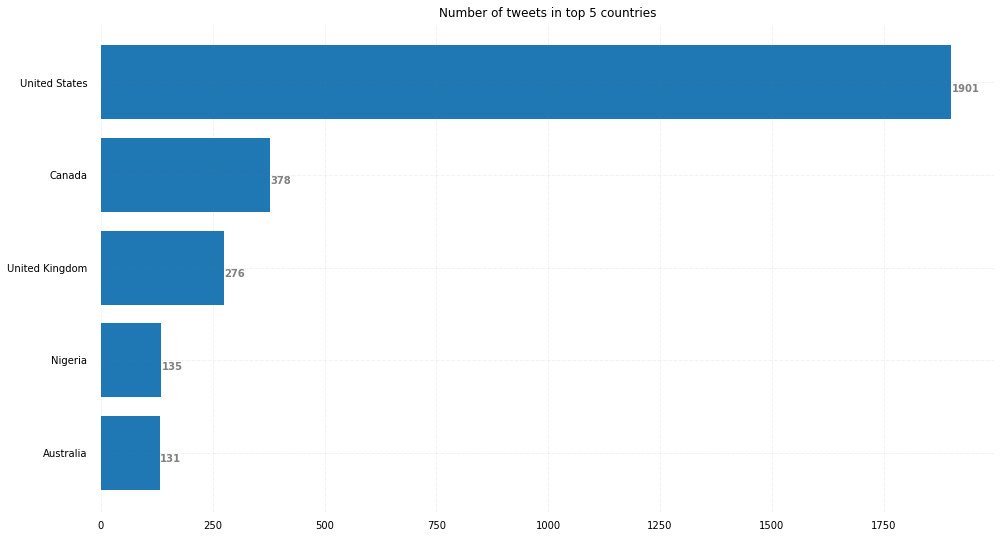

In [ ]:
sorted_unique_countries = sorted(unique_countries.items(), key=itemgetter(1), reverse=True)
first_n_nodes_barplot(sorted_unique_countries, 5, "Number of tweets in top 5 countries")

## User

In [ ]:
verified_users = uu_df['Verified'].value_counts().to_frame().T

In [ ]:
verified_users

,False,True
Verified,5574,221


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



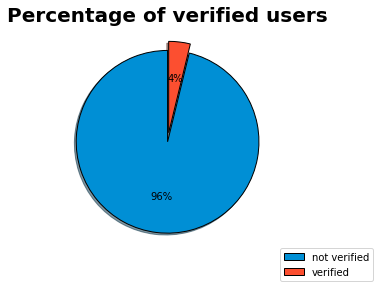

In [ ]:
# Percentage of verified users
fig, ax = plt.subplots()

labels = 'not verified', 'verified'
colors = ['#008fd5', '#fc4f30']
explode = (0, 0.1)

plt.title('Percentage of verified users', fontsize=20, fontweight='bold')
plt.tight_layout()

ax.pie(verified_users, startangle=90, colors=colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.f%%', explode=explode, shadow=True)

fig.legend(loc = 'lower right', labels=labels, fontsize='medium')

plt.show()

## Mentions

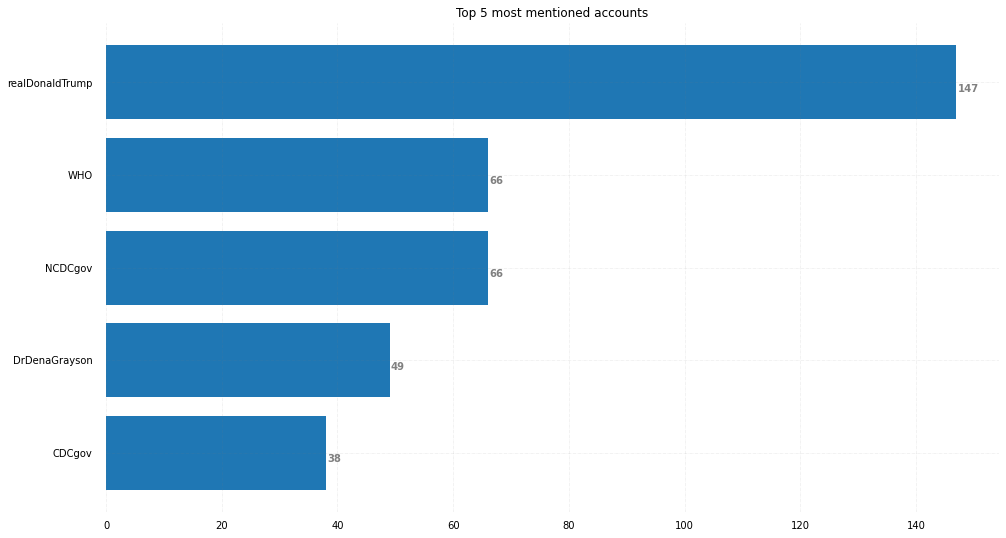

In [ ]:
sorted_unique_mentions = sorted(unique_mentions.items(), key=itemgetter(1), reverse=True)
first_n_nodes_barplot(sorted_unique_mentions, 5, "Top 5 most mentioned accounts")

## WordCloud

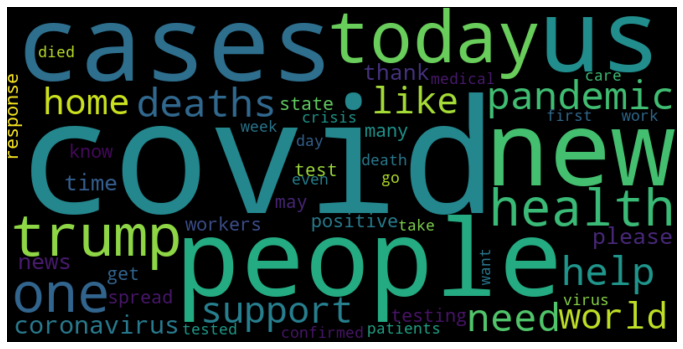

In [ ]:
# Words
wordcloud_plot(unique_words)

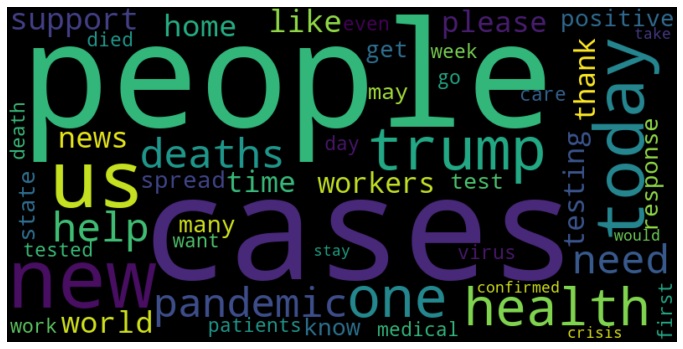

In [ ]:
# Words without covid
wordcloud_plot(unique_words_nocovid)

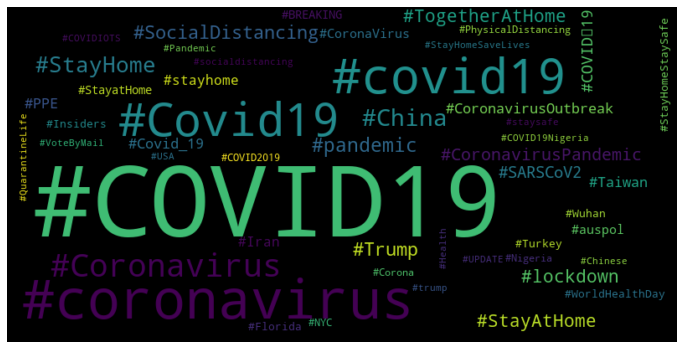

In [ ]:
# Hashtags
wordcloud_plot(unique_hashtags)

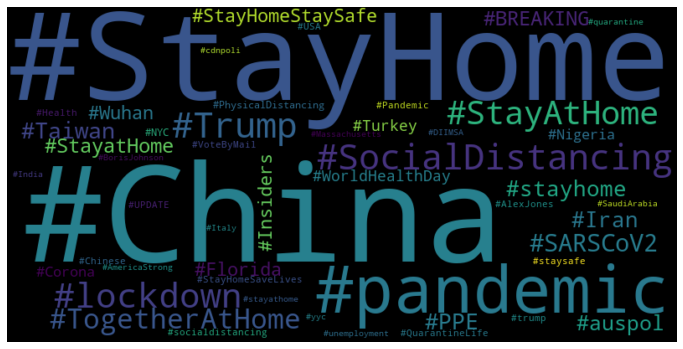

In [ ]:
# Hashtags without covid
wordcloud_plot(unique_hashtags_nocovid)

# Building Network

## Creating nodes

In [ ]:
def create_user_nodes(unique_users_df, filename):
  # User nodes
  user_nodes = unique_users_df.copy()
  user_nodes["Label"] = user_nodes["User"]
  user_nodes.rename(columns={"User":"Id"},inplace=True)
  user_nodes = user_nodes.drop(columns=['Count'])
  user_nodes.to_csv(path + filename,index=False)

  return user_nodes

In [ ]:
def create_word_nodes(unique_words_df, filename):
  # Word nodes
  word_nodes = unique_words_df.copy()
  word_nodes["Label"] = word_nodes["Word"]
  word_nodes.rename(columns={"Word":"Id"},inplace=True)
  word_nodes = word_nodes.drop(columns=['Count'])
  word_nodes.to_csv(path + filename,index=False)

  return word_nodes

In [ ]:
def create_hashtag_nodes(unique_hashtags_df, filename):
  # Hashtag nodes
  hashtag_nodes = unique_hashtags_df.copy()
  hashtag_nodes["Label"] = hashtag_nodes["Hashtag"]
  hashtag_nodes.rename(columns={"Hashtag":"Id"},inplace=True)
  hashtag_nodes = hashtag_nodes.drop(columns=['Count'])
  hashtag_nodes.to_csv(path + filename,index=False)

  return hashtag_nodes

In [ ]:
def create_mention_nodes(unique_mentions_df, filename):
  # Mention nodes
  mention_nodes = unique_mentions_df.copy()
  mention_nodes["Label"] = mention_nodes["Mention"]
  mention_nodes.rename(columns={"Mention":"Id"},inplace=True)
  mention_nodes = mention_nodes.drop(columns=['Count'])
  mention_nodes.to_csv(path + filename,index=False)

  return mention_nodes

In [ ]:
user_nodes = create_user_nodes(uu_df, 'usernodes.csv')
word_nodes = create_word_nodes(uw_df, 'wordnodes.csv')
hashtag_nodes = create_hashtag_nodes(uh_df, 'hashtagnodes.csv')
mention_nodes = create_mention_nodes(um_df, 'mentionnodes.csv')

In [ ]:
list_hashtags = unique_hashtags.keys()
list_words = unique_words.keys() 
list_mentions = unique_mentions.keys()
list_hashtags_nocovid = unique_hashtags_nocovid.keys()

## User network

In [ ]:
tweets_filtered_copy = tweets_filtered.copy()

In [ ]:
a = []
for i in range(tweets_filtered_copy.shape[0]):
  a.append([tweets_filtered_copy['user_name'][i]])

tweets_filtered_copy['user_name'] = a

In [ ]:
tweets_filtered_copy.head()

,created_at,id_str,text,user,retweeted_status,quote_count,reply_count,retweet_count,favorite_count,entities,clean_text,text_tokenized,user_location,user_name,hashtags,mentions
0,Sun Mar 15 23:59:59 +0000 2020,1239340600383746049,RT @danielsgoldman: FINAL UPDATE (thread): My #COVID19 test came back positive. \n\nI want to th...,"{'id': 64090063, 'id_str': '64090063', 'name': 'Dan Maurer', 'screen_name': 'reruam', 'location'...","{'created_at': 'Sun Mar 15 17:26:13 +0000 2020', 'id': 1239241504226508802, 'id_str': '123924150...",0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'COVID19', 'indices': [46, 54]}], 'urls': [], 'user_mentions': [{'screen_...",final update thread my test came back positive i want to thank everyone for the outpouring of s...,"[final, update, thread, test, came, back, positive, want, thank, everyone, outpouring, support]",NaN,[reruam],[COVID19],[danielsgoldman]
1,Sun Mar 15 23:59:59 +0000 2020,1239340599905529859,7) It's just a matter of time. The growth rate of #covid19 is really very high. \nLOCKDOWN #Indi...,"{'id': 140772348, 'id_str': '140772348', 'name': 'Kranthi Thej Kandula', 'screen_name': 'kthej',...",NaN,0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'covid19', 'indices': [50, 58]}, {'text': 'India', 'indices': [90, 96]}, ...",7 its just a matter of time the growth rate of is really very high lockdown asap …,"[matter, time, growth, rate, really, high, lockdown, asap]",Italy,[kthej],"[covid19, India, SAARC]",[]
2,Sun Mar 15 23:59:59 +0000 2020,1239340599544811522,Do your patriotic duty\n- Stay home\n- Clean hands frequently w alcohol-based hand rub or soap &...,"{'id': 17325149, 'id_str': '17325149', 'name': 'Saad Abedine 🤬😷🤟🏼', 'screen_name': 'SaadAbedine'...",NaN,0.0,1.0,3.0,0.0,"{'hashtags': [], 'urls': [{'url': 'https://t.co/LDxqe2UJV1', 'expanded_url': 'https://twitter.co...",do your patriotic duty stay home clean hands frequently w alcoholbased hand rub or soap water...,"[patriotic, duty, stay, home, clean, hands, frequently, w, alcoholbased, hand, rub, soap, water,...",None,[SaadAbedine],[],[]
3,Sun Mar 15 23:59:59 +0000 2020,1239340599343538176,"Even as supply chains face disruption in the near term from the #coronavirus disease (#COVID19),...","{'id': 2950739564, 'id_str': '2950739564', 'name': 'Connect Commercial Real Estate', 'screen_nam...",NaN,0.0,0.0,2.0,10.0,"{'hashtags': [{'text': 'coronavirus', 'indices': [64, 76]}, {'text': 'COVID19', 'indices': [86, ...",even as supply chains face disruption in the near term from the disease in the longer term…,"[even, supply, chains, face, disruption, near, term, disease, longer, term]",United States,[connectCRE],"[coronavirus, COVID19]",[]
4,Sun Mar 15 23:59:59 +0000 2020,1239340599213535233,RT @micheljessica_: Wasn’t even scared until all the grocery stores started clearing out. I’m no...,"{'id': 20729264, 'id_str': '20729264', 'name': 'Molly Hazelrig', 'screen_name': 'mollymorgana', ...","{'created_at': 'Sat Mar 14 07:21:35 +0000 2020', 'id': 1238726956180373504, 'id_str': '123872695...",0.0,0.0,0.0,0.0,"{'hashtags': [], 'urls': [], 'user_mentions': [{'screen_name': 'micheljessica_', 'name': 'Jessic...",wasn’t even scared until all the grocery stores started clearing out i’m not afraid of covid19 ...,"[even, scared, grocery, stores, started, clearing, afraid, covid, scary]",United States,[mollymorgana],[],[micheljessica_]


In [ ]:
def user_network(data_filtered, filename):
  network_users = []
  for index, row in data_filtered.iterrows():
      combined_list = [u for u in row['user_name']]
      #itertool product creates Cartesian product of each element in the combined list
      for pair in itertools.product(combined_list, combined_list):
          #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
          network_users.append(pair)
    
  network_users_df = pd.DataFrame(network_users)

  G = nx.Graph()
  G.add_edges_from(network_users)
  nx.write_edgelist(G, filename, delimiter=",", data = False)

  return G, network_users, network_users_df

In [ ]:
G_users, users_nw, users_nw_df = user_network(tweets_filtered_copy, path+'edgelist_users.csv')

## Words network

In [ ]:
def words_network(data_filtered, list_words, filename):
  network_words = []
  for index, row in data_filtered.iterrows():
      combined_list = [word for word in row["text_tokenized"] if word in list_words]
      #itertool product creates Cartesian product of each element in the combined list
      for pair in itertools.product(combined_list, combined_list):
          #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
          network_words.append(pair)
    
  network_words_df = pd.DataFrame(network_words)

  G = nx.Graph()
  G.add_edges_from(network_words)
  nx.write_edgelist(G, filename, delimiter=",", data = False)

  return G, network_words, network_words_df

In [ ]:
G_words, words_nw, words_nw_df = words_network(tweets_filtered, list_words, path+'edgelist_words.csv')

In [ ]:
words_nw_df

,0,1
0,final,final
1,final,update
2,final,thread
3,final,test
4,final,came
...,...,...
609632,afraid,us
609633,afraid,ready
609634,afraid,covid
609635,afraid,instead


## Hashtags network

In [ ]:
def hashtags_network(data_filtered, list_hashtags, filename):
  network_hashtags = []
  for index, row in data_filtered.iterrows():
    combined_list = ['#'+hashtag for hashtag in row["hashtags"] if '#'+hashtag in list_hashtags]
    for pair in itertools.product(combined_list, combined_list):
      network_hashtags.append(pair)
    
  network_hashtags_df = pd.DataFrame(network_hashtags)

  G = nx.Graph()
  G.add_edges_from(network_hashtags)
  nx.write_edgelist(G, filename, delimiter=",", data = False)

  return G, network_hashtags, network_hashtags_df

In [ ]:
G_hashtags, hashtags_nw, hashtags_nw_df = hashtags_network(tweets_filtered, list_hashtags, path+'edgelist_hashtags.csv')

In [ ]:
G_hashtags_nocovid, hashtags_nw_nocovid, hashtags_nw_df_nocovid = hashtags_network(tweets_filtered, list_hashtags_nocovid, path+'edgelist_hashtags_nocovid.csv')

In [ ]:
hashtags_nw_df

,0,1
0,#COVID19,#COVID19
1,#covid19,#covid19
2,#covid19,#India
3,#covid19,#SAARC
4,#India,#covid19
...,...,...
12872,#ArtificialIntelligence,#ArtificialIntelligence
12873,#ArtificialIntelligence,#Pandemic
12874,#Pandemic,#ArtificialIntelligence
12875,#Pandemic,#Pandemic


## Mentions network

In [ ]:
def mentions_network(data_filtered, list_mentions, filename):
  network_mentions = []
  for index, row in data_filtered.iterrows():
      combined_list = [mention for mention in row["mentions"] if mention in list_mentions]
      #itertool product creates Cartesian product of each element in the combined list
      for pair in itertools.product(combined_list, combined_list):
          #exclude self-loops and count each pair only once because our graph is undirected and we do not take self-loops into account
          network_mentions.append(pair)
    
  network_mentions_df = pd.DataFrame(network_mentions)

  G = nx.Graph()
  G.add_edges_from(network_mentions)
  nx.write_edgelist(G, filename, delimiter=",", data = False)

  return G, network_mentions, network_mentions_df

In [ ]:
G_mentions, mentions_nw, mentions_nw_df = mentions_network(tweets_filtered, list_mentions, path+'edgelist_mentions.csv')

# Network Analysis

In [ ]:
# Define a function to calculate basic properties of network
def graph_analysis(G):
  # Number of nodes and edges
  print('Number of nodes:', len(G.nodes()))
  print('Number of edges:', len(G.edges()))

  # Network density
  density = nx.density(G)
  print("Network density:", density)

  # Network diameter
  if nx.is_connected(G) == False:
    print('Network is not connected!')
    components = nx.connected_components(G)
    largest_component = max(components, key=len)
    giant_component = G.subgraph(largest_component)
    print('Number of components:', nx.number_connected_components(G))
    print('Number of nodes in largest component: {} ({}%)'.format(len(largest_component), round(100*len(largest_component)/len(G.nodes()),3)))
    print('Number of edges in largest component: {} ({}%)'.format(len(giant_component.edges()), round(100*len(giant_component.edges())/len(G.edges()),3)))

    diameter = nx.diameter(giant_component)
    print("Network diameter of largest component:", diameter)

  # Network triadic closure
  triadic_closure = nx.transitivity(G)
  print("Triadic closure:", triadic_closure)

  # Network degree
  degree_dict = dict(G.degree(G.nodes()))
  nx.set_node_attributes(G, degree_dict, 'Degree')

  sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
  print('Range of degree: {} - {}'.format(np.min(list(degree_dict.values())), np.max(list(degree_dict.values()))))

  # Average clustering coefficient for the graph G
  print('Average clustering coefficient:',nx.average_clustering(G))

  return sorted_degree, G

In [ ]:
def plot_degree_distribution(sorted_degree):
  sorted_degree_dict = dict(sorted_degree) # Change to dictionary
  d = Counter(sorted_degree_dict.values())
  x = list(Counter(d).keys())
  y = list(Counter(d).values())
  y = y/np.sum(y)
  Pk = 1 - np.cumsum(y) # Complementary cumulative
  Pk[-1] = 1
  Pk = sorted(Pk, reverse = False)
  plt.figure(figsize=(60, 60))

  plt.subplot(8, 6, 1)
  plt.loglog(x, y, 'o', markersize = 4)
  plt.grid(which='both', linestyle='--', linewidth=0.5)
  plt.title("Degree Distribution", size = 20)
  plt.xlabel("k", size = 18)
  plt.ylabel("p_k", size = 18)

  plt.subplot(8, 6, 2)
  plt.loglog(x, Pk, 'o', markersize = 4)
  plt.grid(which='both', linestyle='--', linewidth=0.5)
  plt.title("CCDF", size = 20)
  plt.xlabel("k", size = 18)
  plt.ylabel("P_k", size = 18)
  plt.show()

In [ ]:
def extract_n_most_highest_indexes(dictionary, n):
  sorted_list = sorted(dictionary.items(), key=itemgetter(1), reverse=True)
  return sorted_list[:n]

In [ ]:
def degree_distribution(degree_dict, kmin, fitting_gamma = 'yes'):
  d = np.array(list(degree_dict.values()))
  sorted_d = sorted(d)
  occurrence = Counter(sorted_d)
  x = list(Counter(occurrence).keys()) #values of the degrees
  y = list(Counter(occurrence).values()) #counters for each degree
  y = y/np.sum(y)
  Pk = 1 - np.cumsum(y) # complementary cumulative distribution function (CCDF)

  # set the last value of Pk (that is equal to 0 and generates problems when plotting in the log-scale) 
  # equal to 1 and sort Pk in decreasing order to put the 1 at the beginning of the array
  Pk[-1] = 1 
  Pk = sorted(Pk, reverse = True)

  # Discard samples in the saturation region, i.e. samples with degree < kmin
  kmin = kmin # multiple values have been tried (with k = 50 the resulting fit is good)

  # Fit gamma only in the chosen interval
  d2 = d[d>kmin]
  ga = 1 + 1/mean(np.log(d2/kmin)) # ML estimate for gamma
  if fitting_gamma == 'yes':
    print("Estimated \u03B3 =", ga)
  
  C = (ga-1)*kmin**(ga-1) # normalization condition
  if fitting_gamma == 'yes':
    print("log(C) = ", np.log(C))

  # The fit is performed for values of k > kmin. So, only part of the data are considered and therefore the total 
  # probability is not 1 but is P_kmin
  pos = np.argmax(np.array(x)>=kmin)
  P_kmin = Pk[pos] # constant value that shifts the line where the data are placed

  # degree distribution follows the power law
  pk = C*P_kmin*x**-ga 

  # CCDF 
  Pk_est = C*P_kmin*x**(-(ga-1))/(ga-1)

  # Plot 
  plt.figure(figsize=(20, 15))

  plt.subplot(2, 2, 1)
  plt.loglog(x, y, 'o', markersize = 4)
  if fitting_gamma == 'yes':
    plt.loglog(x, pk, color='orange')
  plt.grid(which='both', linestyle='--', linewidth=0.5)
  plt.title('Linear Binning')

  plt.xlabel("k", size = 18)
  plt.ylabel("$p_k$", size = 18)

  plt.subplot(2, 2, 2)
  plt.loglog(x, Pk, 'o', alpha = 0.5, markersize = 4)
  if fitting_gamma == 'yes':
    plt.loglog(x, Pk_est, color='orange')
  plt.grid(which='both', linestyle='--', linewidth=0.5)
  plt.title('Cumulative')

  plt.xlabel("k", size = 18)
  plt.ylabel("$P_k$", size = 18)
  plt.suptitle('Degree distribution with estimated \u03B3 ={}'.format(np.round(ga, 5)), size = 18)
  plt.show()

In [ ]:
# Define a function to compare between centrality measures
def centralities_comparison(deg_cent, bet_cent, clo_cent, eig_cent, pag_rank):
  fig, ax = plt.subplots(4, 1, figsize = (10,10), sharex=True, sharey= False)

  ax[0].barh(*zip(*deg_cent), color = 'royalblue')
  ax[0].invert_yaxis()
  ax[0].set_title('Degree Centrality')

  ax[1].barh(*zip(*bet_cent), color = 'orangered')
  ax[1].invert_yaxis()
  ax[1].set_title('Betweensess Centrality')

  ax[2].barh(*zip(*clo_cent), color = 'forestgreen')
  ax[2].invert_yaxis()
  ax[2].set_title('Closeness Centrality')

  ax[3].barh(*zip(*eig_cent), color = 'gold')
  ax[3].invert_yaxis()
  ax[3].set_title('Eigenvector Centrality')

  plt.suptitle("Centralities Comparison", fontsize = 20)
  plt.show()

In [ ]:
# Defining functions for counting the occurrence of clustering coefficient
def count_range_in_list(li, min, max):
	ctr = 0
	for x in li:
		if min <= x <= max:
			ctr += 1
	return ctr

def count_cc(list_values):  
  result = []
  for i in list(np.arange(0, 1.1, step=0.1)):
    if i < 1:
      result.append(count_range_in_list(list_values, i, i + 0.1))
  return result

## Words network

In [ ]:
# Number of nodes and edges
print('Number of nodes:', len(G_words.nodes()))
print('Number of edges:', len(G_words.edges()))

Number of nodes: 11823
Number of edges: 212882


In [ ]:
# Network density
density = nx.density(G_words)
print("Network density:", density)

Network density: 0.003046143038624768


In [ ]:
# Network diameter
if nx.is_connected(G_words) == False:
  print('Network is not connected!')
  components = nx.connected_components(G_words)
  largest_component = max(components, key=len)
  giant_component = G_words.subgraph(largest_component)
  print('Number of components:', nx.number_connected_components(G_words))
  print('Number of nodes in largest component: {} ({}%)'.format(len(largest_component), round(100*len(largest_component)/len(G_words.nodes()),3)))
  print('Number of edges in largest component: {} ({}%)'.format(len(giant_component.edges()), round(100*len(giant_component.edges())/len(G_words.edges()),3)))

  diameter = nx.diameter(giant_component)
  print("Network diameter of largest component:", diameter)

Number of components: 13
Number of nodes in largest component: 11808 (99.873%)
Number of edges in largest component: 212864 (99.992%)
Network diameter of largest component: 5


In [ ]:
# Average clustering coefficient
print('Average clustering coefficient:',nx.average_clustering(G_words))

Average clustering coefficient: 0.7343749370336387


In [ ]:
# Network triadic closure
triadic_closure_words_nw = nx.transitivity(G_words)
print("Triadic closure:", triadic_closure_words_nw)

Triadic closure: 0.09781843378348645


In [ ]:
# Network degree
degree_dict = dict(G_words.degree(G_words.nodes()))
nx.set_node_attributes(G_words, degree_dict, 'Degree')

sorted_degree_words = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
print('Range of degree: {} - {}'.format(np.min(list(degree_dict.values())), np.max(list(degree_dict.values()))))

Range of degree: 2 - 3310


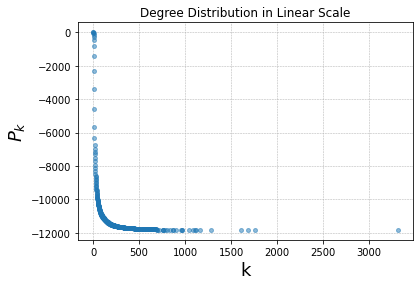

In [ ]:
# Ploting degree distribution in linear scale
d = np.array(list(degree_dict.values()))
sorted_d = sorted(d)
occurrence = Counter(sorted_d)
x = list(Counter(occurrence).keys()) #values of the degrees
y = list(Counter(occurrence).values()) #counters for each degree
Pk = 1 - np.cumsum(y)
Pk[-1] = 1 
Pk = sorted(Pk, reverse = True)
plt.plot(x, Pk, 'o', alpha = 0.5, markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title('Degree Distribution in Linear Scale')
plt.xlabel("k", size = 18)
plt.ylabel("$P_k$", size = 18)
plt.show()

Estimated γ = 2.2186922434177525
log(C) =  4.965330444977861


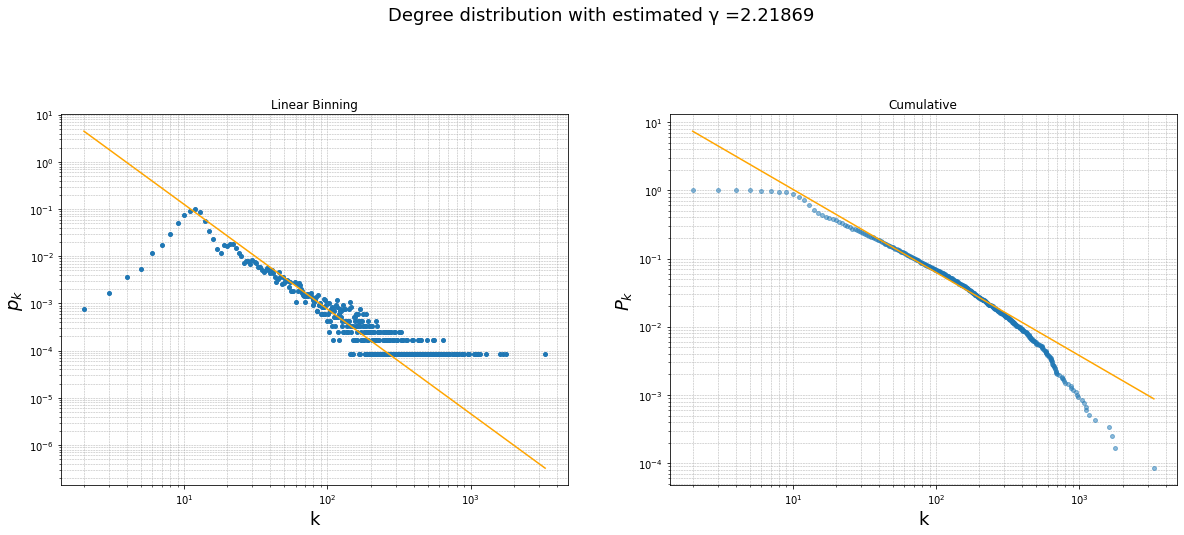

In [ ]:
# Ploting degree distribution in log-log scale
degree_distribution(degree_dict, kmin = 50, fitting_gamma='yes')

In [ ]:
# Network properties extracted from Gephi
G_words_final = pd.read_csv(path + 'words_node_statistics_2020.csv')

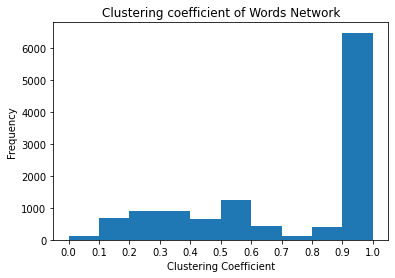

In [ ]:
# Clustering coefficient
clustering_coefficient = dict(zip(G_words_final['Id'], G_words_final['clustering']))

# Ploting the clustering coefficient distribution
xticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
list_values = count_cc(clustering_coefficient.values())
plt.bar(np.arange(len(list_values)) , list_values, align='edge', width=1.0)
plt.xticks(ticks = np.arange(len(list_values) + 1), labels = xticks)
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.title("Clustering coefficient of Words Network")
plt.show()

In [ ]:
# Counting number of clustering coefficient equal to 0 and 1
cc_0 = sum(value == 0 for value in clustering_coefficient.values())
print('Number of clustering coefficient equal to 0: {} ({}%)'.format(cc_0, np.round(cc_0*100/len(clustering_coefficient),2)))

cc_1 = sum(value == 1 for value in clustering_coefficient.values())
print('Number of clustering coefficient equal to 1: {} ({}%)'.format(cc_1, np.round(cc_1*100/len(clustering_coefficient),2)))

Number of clustering coefficient equal to 0: 13 (0.11%)
Number of clustering coefficient equal to 1: 1180 (9.98%)


In [ ]:
# Normalized degree centrality
norm = sorted([float(i)/max(G_words_final['Degree']) for i in G_words_final['Degree']], reverse = True)

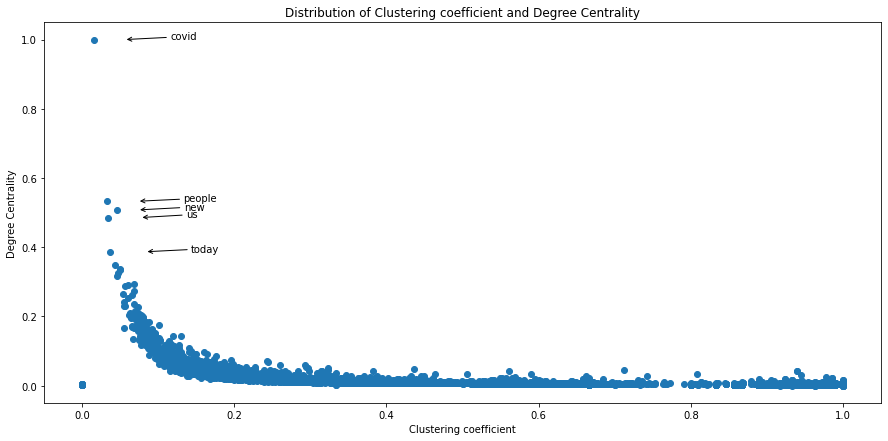

In [ ]:
# Relationship between Degree centrality and Clustering Coefficient
list_highest_degree_centrality = ['covid', 'people', 'new', 'us', 'today']
fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(clustering_coefficient.values(), norm)
ax.set_xlabel('Clustering coefficient')
ax.set_ylabel('Degree Centrality')
ax.set_title('Distribution of Clustering coefficient and Degree Centrality')
for i, txt in enumerate(list_highest_degree_centrality):
    ax.annotate(txt, xy = (clustering_coefficient[txt] + 0.04, norm[0+i]),
                xytext = (clustering_coefficient[txt] + 0.1, norm[0+i]), 
                arrowprops={'arrowstyle': '->'})
plt.show()

In [ ]:
# Clustering coefficient of the highest degree centrality
print("Clustering coefficient of the highest degree centrality:",clustering_coefficient['covid'])

Clustering coefficient of the highest degree centrality: 0.015871


In [ ]:
sorted_cc = sorted(clustering_coefficient.items(), key=itemgetter(1), reverse=False)
sorted_cc

[('erd', 0.0),
 ('tread', 0.0),
 ('rambling', 0.0),
 ('sysop', 0.0),
 ('medicat', 0.0),
 ('contagion', 0.0),
 ('riiiiiiight', 0.0),
 ('preventable', 0.0),
 ('selfie', 0.0),
 ('introverts', 0.0),
 ('rocks', 0.0),
 ('battlin', 0.0),
 ('hiking', 0.0),
 ('covid', 0.015871),
 ('people', 0.033174),
 ('new', 0.033511),
 ('us', 0.036611),
 ('today', 0.043297),
 ('pandemic', 0.045804),
 ('cases', 0.045845),
 ('health', 0.047291),
 ('trump', 0.049753),
 ('one', 0.050051),
 ('like', 0.054198),
 ('coronavirus', 0.05523),
 ('time', 0.055668),
 ('dr', 0.055686),
 ('need', 0.0559),
 ('news', 0.056462),
 ('help', 0.059869),
 ('world', 0.060015),
 ('many', 0.061941),
 ('state', 0.062325),
 ('patients', 0.063931),
 ('may', 0.064502),
 ('due', 0.065043),
 ('home', 0.065212),
 ('response', 0.065463),
 ('says', 0.065519),
 ('president', 0.067147),
 ('government', 0.067964),
 ('deaths', 0.068296),
 ('please', 0.068804),
 ('support', 0.068834),
 ('testing', 0.068898),
 ('medical', 0.070135),
 ('day', 0.07121

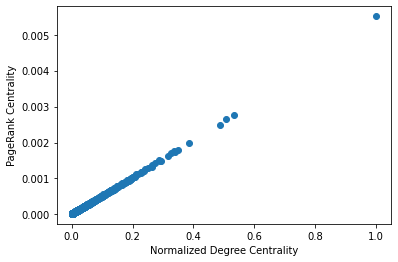

In [ ]:
# Relationship between Degree centrality and PageRank
plt.scatter(norm, G_words_final['pageranks'])
plt.xlabel('Normalized Degree Centrality')
plt.ylabel('PageRank Centrality')
plt.show()

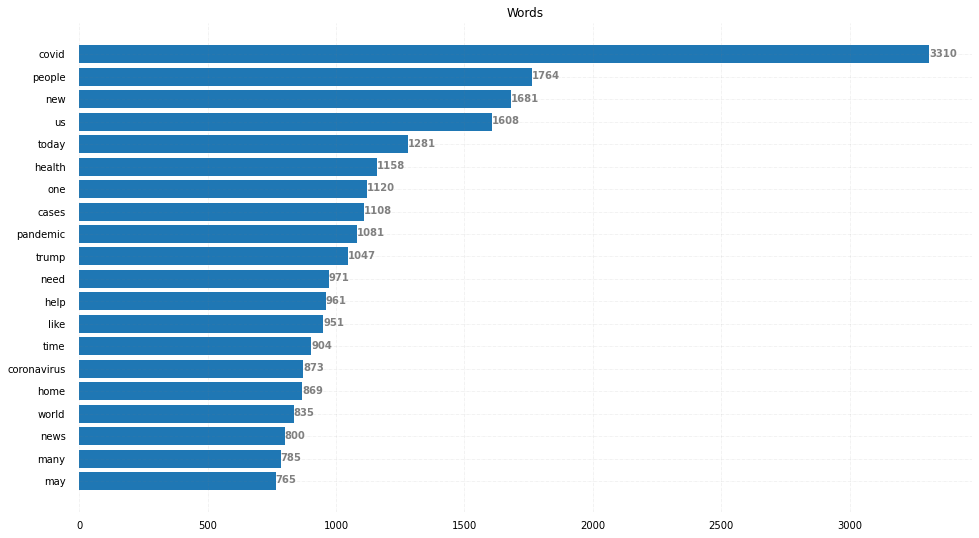

In [ ]:
# First 20 nodes have the highest degree 
first_n_nodes_barplot(sorted_degree_words, 20, "Words")

### Sorted centrality comparison

In [ ]:
degree_centrality_words = nx.degree_centrality(G_words)
betweenness_centrality_words = dict(zip(G_words_final['Id'], G_words_final['betweenesscentrality']))
closeness_centrality_words = dict(zip(G_words_final['Id'], G_words_final['closnesscentrality']))
pageranks_words = dict(zip(G_words_final['Id'], G_words_final['pageranks']))
modularity_class_words = dict(zip(G_words_final['Id'], G_words_final['modularity_class']))
eigen_centrality_words = dict(zip(G_words_final['Id'], G_words_final['eigencentrality']))

In [ ]:
print('Degree centrality:')
deg_cent = extract_n_most_highest_indexes(degree_centrality_words, 5)
deg_cent_df = pd.DataFrame(deg_cent, columns = ['Word', 'Value'])
deg_cent_df

Degree centrality:


,Word,Value
0,covid,0.279986
1,people,0.149213
2,new,0.142193
3,us,0.136018
4,today,0.108357


In [ ]:
print('Betweenness centrality:')
bet_cent = extract_n_most_highest_indexes(betweenness_centrality_words, 5)
bet_cent_df = pd.DataFrame(bet_cent, columns = ['Word', 'Value'])
bet_cent_df

Betweenness centrality:


,Word,Value
0,covid,0.140182
1,people,0.040855
2,new,0.039358
3,us,0.034101
4,today,0.024973


In [ ]:
print('Closeness centrality:')
clo_cent = extract_n_most_highest_indexes(closeness_centrality_words, 5)
clo_cent_df = pd.DataFrame(clo_cent, columns = ['Word', 'Value'])
clo_cent_df

Closeness centrality:


,Word,Value
0,pa7,1.0
1,anime,1.0
2,emojis,1.0
3,describe,1.0
4,necker,1.0


In [ ]:
# Percentage of nodes have closeness centrality equal to 1
count_closeness = sum(value == 1 for value in closeness_centrality_words.values())
print("Percentage of nodes have closeness centrality equal to 1: {}%".format(np.round(count_closeness*100/len(closeness_centrality_words),2)))

Percentage of nodes have closeness centrality equal to 1: 0.05%


In [ ]:
print('EigenCentrality:')
eig_cent = extract_n_most_highest_indexes(eigen_centrality_words, 5)
eig_cent_df = pd.DataFrame(eig_cent, columns = ['Word', 'Value'])
eig_cent_df

EigenCentrality:


,Word,Value
0,covid,1.000000
1,people,0.693908
2,new,0.658107
3,us,0.656681
4,today,0.552922


In [ ]:
print('PageRank:')
pag_rank = extract_n_most_highest_indexes(pageranks_words, 5)
pag_rank_df = pd.DataFrame(pag_rank, columns = ['Word', 'Value'])
pag_rank_df

PageRank:


,Word,Value
0,covid,0.005513
1,people,0.002764
2,new,0.002644
3,us,0.002497
4,today,0.001998


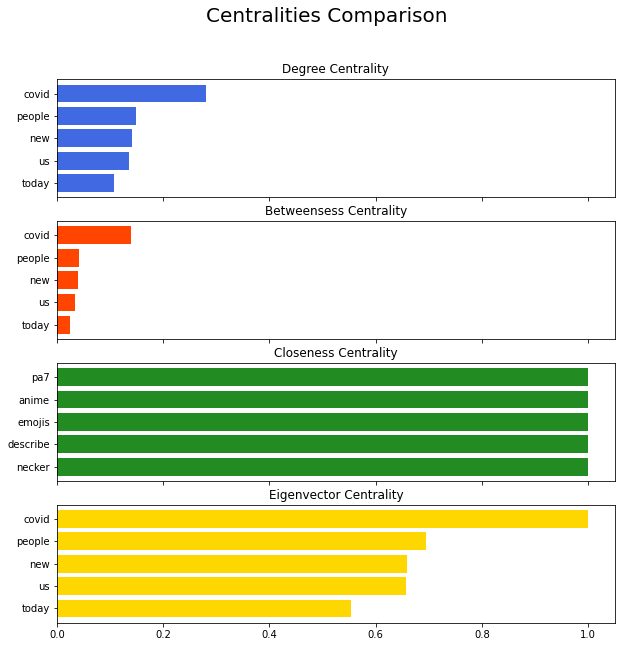

In [ ]:
centralities_comparison(deg_cent, bet_cent, clo_cent, eig_cent, pag_rank)

## Hashtags network

In [ ]:
# Number of nodes and edges
print('Number of nodes:', len(G_hashtags.nodes()))
print('Number of edges:', len(G_hashtags.edges()))

Number of nodes: 1652
Number of edges: 4634


In [ ]:
sorted_degree_hashtags, graph_hashtags = graph_analysis(G_hashtags)

Number of nodes: 1652
Number of edges: 4634
Network density: 0.0033980433019536183
Network is not connected!
Number of components: 329
Number of nodes in largest component: 1215 (73.547%)
Number of edges in largest component: 4040 (87.182%)
Network diameter of largest component: 7
Triadic closure: 0.026454078271181975
Range of degree: 2 - 812
Average clustering coefficient: 0.5464589103215532


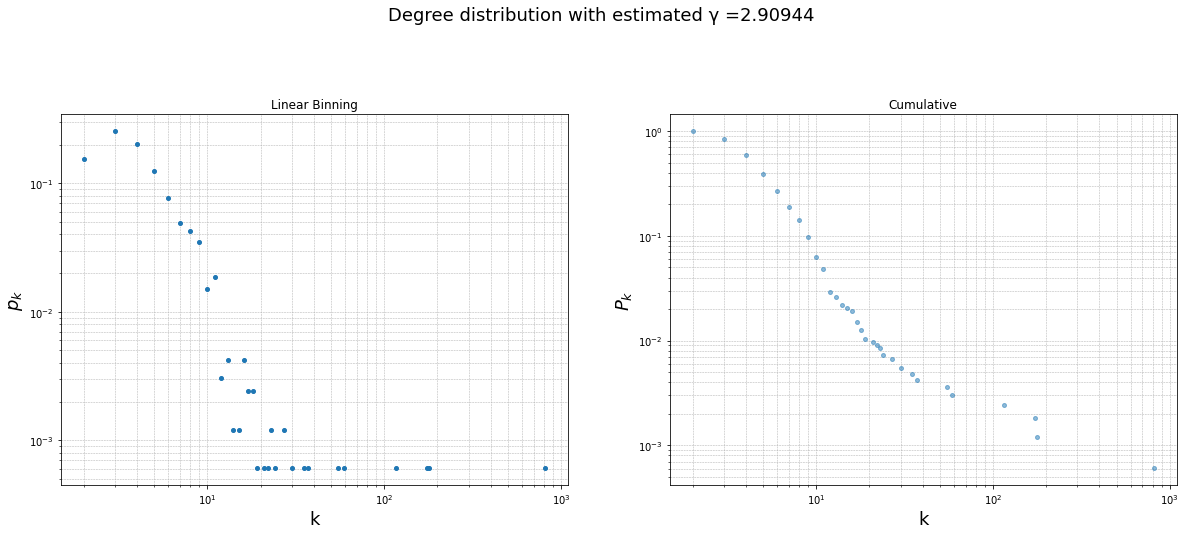

In [ ]:
# Degree distribution in log-log scale
degree_dict = dict(G_hashtags.degree(G_hashtags.nodes()))
degree_distribution(degree_dict, 10, fitting_gamma = 'no')

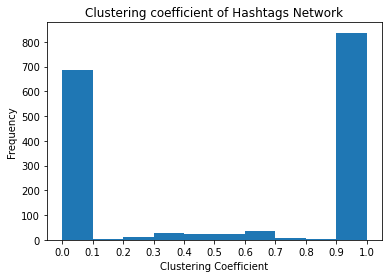

In [ ]:
# Clustering coefficient distribution
clustering_coefficient_hashtags = nx.clustering(G_hashtags)

# Ploting clustering coefficient distribution
xticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
list_values = count_cc(clustering_coefficient_hashtags.values())
plt.bar(np.arange(len(list_values)) , list_values, align='edge', width=1.0)
plt.xticks(ticks = np.arange(len(list_values) + 1), labels = xticks)
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.title("Clustering coefficient of Hashtags Network")
plt.show()

In [ ]:
# Counting number of clustering coefficient equal to 0 and 1
cc_0 = sum(value == 0 for value in clustering_coefficient_hashtags.values())
print('Number of clustering coefficient equal to 0: {} ({}%)'.format(cc_0, np.round(cc_0*100/len(clustering_coefficient_hashtags),2)))

cc_1 = sum(value == 1 for value in clustering_coefficient_hashtags.values())
print('Number of clustering coefficient equal to 1: {} ({}%)'.format(cc_1, np.round(cc_1*100/len(clustering_coefficient_hashtags),2)))

Number of clustering coefficient equal to 0: 680 (41.16%)
Number of clustering coefficient equal to 1: 834 (50.48%)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 12540 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 12540 missing from current font.



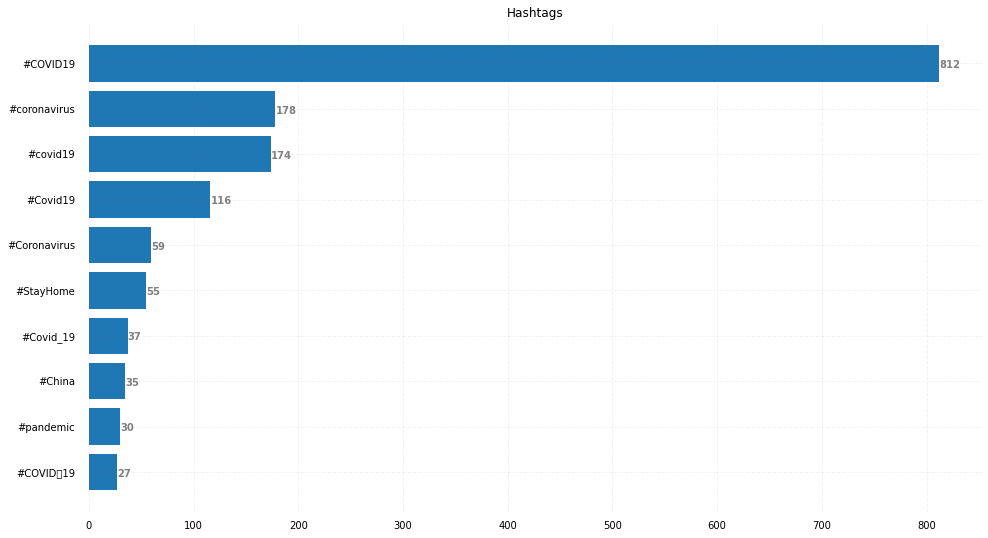

In [ ]:
first_n_nodes_barplot(sorted_degree_hashtags, 10, 'Hashtags')

### Sorted centrality comparison

In [ ]:
# Network properties extracted from Gephi
G_hashtags_final = pd.read_csv(path + 'hashtags_statistics.csv')

In [ ]:
degree_centrality_hashtags = nx.degree_centrality(G_hashtags)
betweenness_centrality_hashtags = dict(zip(G_hashtags_final['Id'], G_hashtags_final['betweenesscentrality']))
closeness_centrality_hashtags = dict(zip(G_hashtags_final['Id'], G_hashtags_final['closnesscentrality']))
pageranks_hashtags = dict(zip(G_hashtags_final['Id'], G_hashtags_final['pageranks']))
eigen_centrality_hashtags = dict(zip(G_hashtags_final['Id'], G_hashtags_final['eigencentrality']))

In [ ]:
print('Degree centrality:')
deg_cent_ht = extract_n_most_highest_indexes(degree_centrality_hashtags, 5)
deg_cent_df = pd.DataFrame(deg_cent_ht, columns = ['Hashtag', 'Value'])
deg_cent_df

Degree centrality:


,Hashtag,Value
0,#COVID19,0.491823
1,#coronavirus,0.107813
2,#covid19,0.105391
3,#Covid19,0.070260
4,#Coronavirus,0.035736


In [ ]:
print('Betweenness centrality:')
bet_cent_ht = extract_n_most_highest_indexes(betweenness_centrality_hashtags, 5)
bet_cent_df = pd.DataFrame(bet_cent_ht, columns = ['Hashtag', 'Value'])
bet_cent_df

Betweenness centrality:


,Hashtag,Value
0,#COVID19,0.446010
1,#covid19,0.069214
2,#coronavirus,0.068034
3,#Covid19,0.063550
4,#Coronavirus,0.018292


In [ ]:
print('Closeness centrality:')
clo_cent_ht = extract_n_most_highest_indexes(closeness_centrality_hashtags, 5)
clo_cent_df = pd.DataFrame(clo_cent_ht, columns = ['Hashtag', 'Value'])
clo_cent_df

Closeness centrality:


,Hashtag,Value
0,#MTOShahmaghsoudi,1.0
1,#DIIMSA,1.0
2,#DIIMSACHALLENGE,1.0
3,#DIIMSAVBOARD,1.0
4,#s,1.0


In [ ]:
# Percentage of nodes have closeness centrality equal to 1
count_closeness = sum(value == 1 for value in closeness_centrality_hashtags.values())
print("Percentage of nodes have closeness centrality equal to 1: {}%".format(np.round(count_closeness*100/len(closeness_centrality_hashtags),2)))

Percentage of nodes have closeness centrality equal to 1: 10.84%


In [ ]:
print('EigenCentrality:')
eig_cent_ht = extract_n_most_highest_indexes(eigen_centrality_hashtags, 5)
eig_cent_df = pd.DataFrame(eig_cent_ht, columns = ['Hashtag', 'Value'])
eig_cent_df

EigenCentrality:


,Hashtag,Value
0,#COVID19,1.000000
1,#coronavirus,0.260623
2,#covid19,0.159783
3,#StayHome,0.113904
4,#Coronavirus,0.108692


In [ ]:
print('PageRank:')
pag_rank_ht = extract_n_most_highest_indexes(pageranks_hashtags, 5)
pag_rank_df = pd.DataFrame(pag_rank_ht, columns = ['Hashtag', 'Value'])
pag_rank_df

PageRank:


,Hashtag,Value
0,#COVID19,0.025720
1,#covid19,0.005214
2,#coronavirus,0.005171
3,#Covid19,0.003580
4,#Coronavirus,0.001758


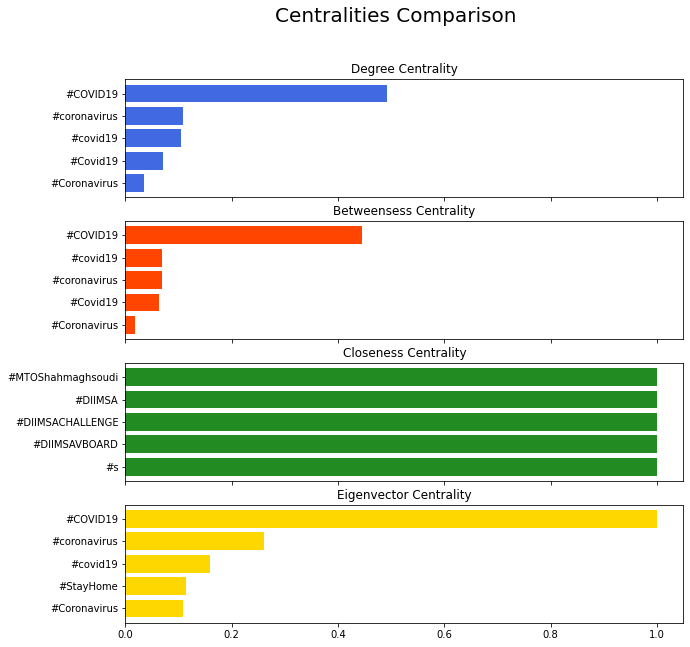

In [ ]:
centralities_comparison(deg_cent_ht, bet_cent_ht, clo_cent_ht, eig_cent_ht, pag_rank_ht)

## Hashtags network without #Covid

In [ ]:
# Number of nodes and edges
print('Number of nodes:', len(G_hashtags_nocovid.nodes()))
print('Number of edges:', len(G_hashtags_nocovid.edges()))

Number of nodes: 1560
Number of edges: 2992


In [ ]:
sorted_degree_hashtags_nocovid, graph_hashtags_nocovid = graph_analysis(G_hashtags_nocovid)

Number of nodes: 1560
Number of edges: 2992
Network density: 0.002460485847272249
Network is not connected!
Number of components: 813
Number of nodes in largest component: 248 (15.897%)
Number of edges in largest component: 774 (25.869%)
Network diameter of largest component: 12
Triadic closure: 0.5822599531615925
Range of degree: 2 - 45
Average clustering coefficient: 0.3640305740416911


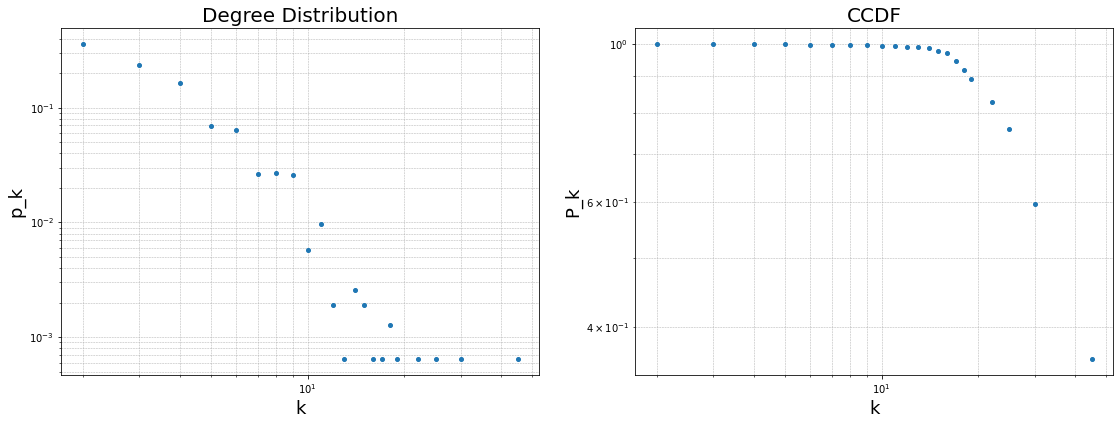

In [ ]:
plot_degree_distribution(sorted_degree_hashtags_nocovid)

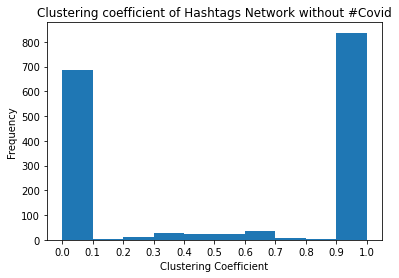

In [ ]:
# Clustering coefficient distribution
clustering_coefficient_hashtags_nocovid = nx.clustering(G_hashtags_nocovid)

# Ploting clustering coefficient distribution
xticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
list_values = count_cc(clustering_coefficient_hashtags.values())
plt.bar(np.arange(len(list_values)) , list_values, align='edge', width=1.0)
plt.xticks(ticks = np.arange(len(list_values) + 1), labels = xticks)
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.title("Clustering coefficient of Hashtags Network without #Covid")
plt.show()

In [ ]:
# Counting number of clustering coefficient equal to 0 and 1
cc_0_nocovid = sum(value == 0 for value in clustering_coefficient_hashtags_nocovid.values())
print('Number of clustering coefficient equal to 0: {} ({}%)'.format(cc_0_nocovid, np.round(cc_0_nocovid*100/len(clustering_coefficient_hashtags_nocovid),2)))

cc_1_nocovid = sum(value == 1 for value in clustering_coefficient_hashtags_nocovid.values())
print('Number of clustering coefficient equal to 1: {} ({}%)'.format(cc_1_nocovid, np.round(cc_1_nocovid*100/len(clustering_coefficient_hashtags_nocovid),2)))

Number of clustering coefficient equal to 0: 948 (60.77%)
Number of clustering coefficient equal to 1: 533 (34.17%)


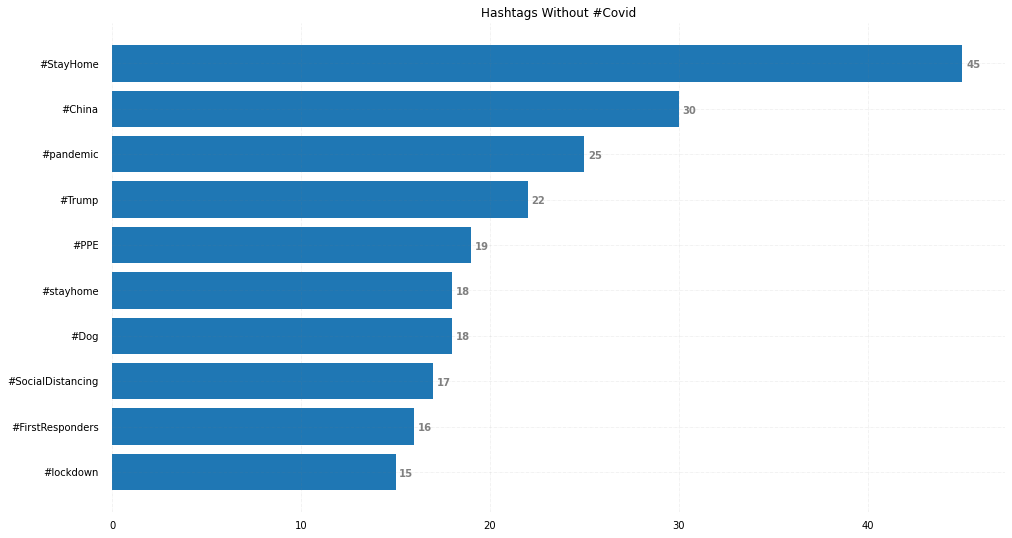

In [ ]:
first_n_nodes_barplot(sorted_degree_hashtags_nocovid, 10, 'Hashtags Without #Covid')

### Sorted centrality comparison

In [ ]:
# Network properties extracted from Gephi
G_hashtags_nocovid_final = pd.read_csv(path + 'hashtags_nocovid_statistics.csv')

In [ ]:
degree_centrality_hashtags_nocovid = nx.degree_centrality(G_hashtags_nocovid)
betweenness_centrality_hashtags_nocovid = dict(zip(G_hashtags_nocovid_final['Id'], G_hashtags_nocovid_final['betweenesscentrality']))
closeness_centrality_hashtags_nocovid = dict(zip(G_hashtags_nocovid_final['Id'], G_hashtags_nocovid_final['closnesscentrality']))
pageranks_hashtags_nocovid = dict(zip(G_hashtags_nocovid_final['Id'], G_hashtags_nocovid_final['pageranks']))
eigen_centrality_hashtags_nocovid = dict(zip(G_hashtags_nocovid_final['Id'], G_hashtags_nocovid_final['eigencentrality']))

In [ ]:
print('Degree centrality:')
deg_cent_nocovid_ht = extract_n_most_highest_indexes(degree_centrality_hashtags_nocovid, 5)
deg_cent_df = pd.DataFrame(deg_cent_nocovid_ht, columns = ['Word', 'Value'])
deg_cent_df

Degree centrality:


,Word,Value
0,#StayHome,0.028865
1,#China,0.019243
2,#pandemic,0.016036
3,#Trump,0.014112
4,#PPE,0.012187


In [ ]:
print('Betweenness centrality:')
bet_cent_nocovid_ht = extract_n_most_highest_indexes(betweenness_centrality_hashtags_nocovid, 5)
bet_cent_df = pd.DataFrame(bet_cent_nocovid_ht, columns = ['Word', 'Value'])
bet_cent_df

Betweenness centrality:


,Word,Value
0,#StayHome,0.014063
1,#China,0.012545
2,#Trump,0.011727
3,#PPE,0.007369
4,#healthcare,0.004959


In [ ]:
print('Closeness centrality:')
clo_cent_nocovid_ht = extract_n_most_highest_indexes(closeness_centrality_hashtags_nocovid, 5)
clo_cent_df = pd.DataFrame(clo_cent_nocovid_ht, columns = ['Hashtag', 'Value'])
clo_cent_df

Closeness centrality:


,Hashtag,Value
0,#TogetherAtHome,1.0
1,#Iran,1.0
2,#VoteByMail,1.0
3,#trump,1.0
4,#Pandemic,1.0


In [ ]:
# Percentage of nodes have closeness centrality equal to 1
count_closeness = sum(value == 1 for value in closeness_centrality_hashtags_nocovid.values())
print("Percentage of nodes have closeness centrality equal to 1: {}%".format(np.round(count_closeness*100/len(closeness_centrality_hashtags_nocovid),2)))

Percentage of nodes have closeness centrality equal to 1: 35.17%


In [ ]:
print('EigenCentrality:')
eig_cent_nocovid_ht = extract_n_most_highest_indexes(eigen_centrality_hashtags_nocovid, 5)
eig_cent_df = pd.DataFrame(eig_cent_nocovid_ht, columns = ['Hashtag', 'Value'])
eig_cent_df

EigenCentrality:


,Hashtag,Value
0,#StayHome,1.000000
1,#Trump,0.533022
2,#China,0.456025
3,#Dog,0.435442
4,#TrumpVirus,0.337891


In [ ]:
pagerank_hashtags_nocovid = nx.get_node_attributes(G_hashtags_nocovid, 'PageRank')
print('PageRank:')
pag_rank_nocovid_ht = extract_n_most_highest_indexes(pageranks_hashtags_nocovid, 5)
pag_rank_df = pd.DataFrame(pag_rank_nocovid_ht, columns = ['Hashtag', 'Value'])
pag_rank_df

PageRank:


,Hashtag,Value
0,#StayHome,0.002080
1,#China,0.001414
2,#pandemic,0.001276
3,#Trump,0.000989
4,#PPE,0.000922


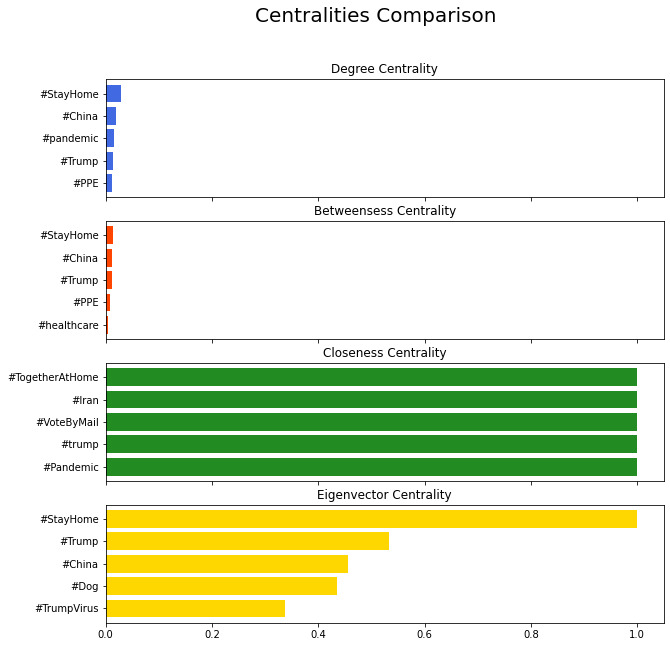

In [ ]:
centralities_comparison(deg_cent_nocovid_ht, bet_cent_nocovid_ht, clo_cent_nocovid_ht, eig_cent_nocovid_ht, pag_rank_nocovid_ht)

## Mentions network

In [ ]:
# Number of nodes and edges
print('Number of nodes:', len(G_mentions.nodes()))
print('Number of edges:', len(G_mentions.edges()))

Number of nodes: 4249
Number of edges: 6690


In [ ]:
sorted_degree_mentions, graph_mentions = graph_analysis(G_mentions)

Number of nodes: 4249
Number of edges: 6690
Network density: 0.0007412844231876427
Network is not connected!
Number of components: 2762
Number of nodes in largest component: 457 (10.755%)
Number of edges in largest component: 1246 (18.625%)
Network diameter of largest component: 12
Triadic closure: 0.36639310057031577
Range of degree: 2 - 110
Average clustering coefficient: 0.20401318621117462


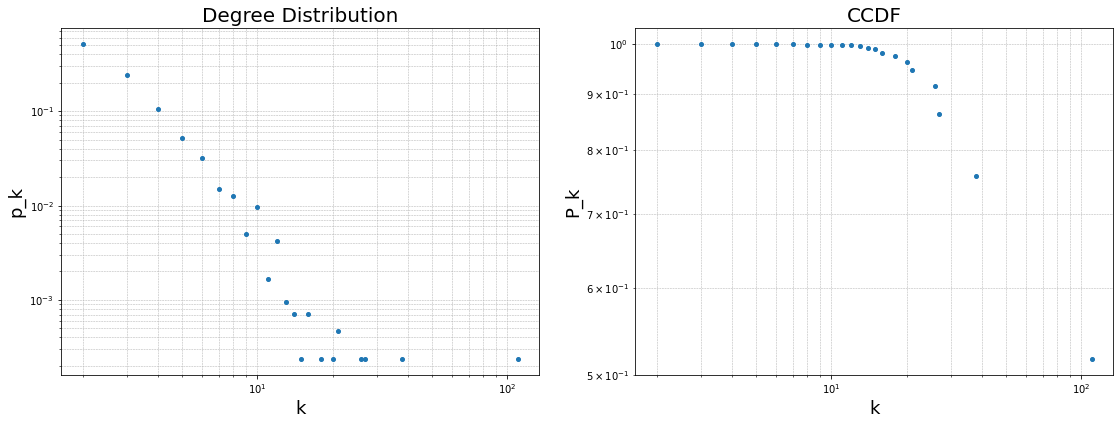

In [ ]:
plot_degree_distribution(sorted_degree_mentions)

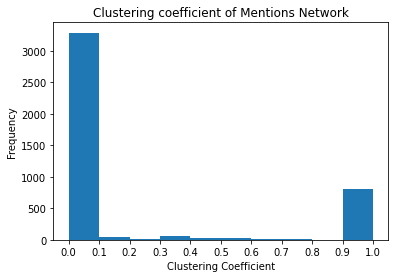

In [ ]:
# Clustering coefficient distribution
clustering_coefficient_mentions = nx.clustering(G_mentions)

# Ploting clustering coefficient distribution
xticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
list_values = count_cc(clustering_coefficient_mentions.values())
plt.bar(np.arange(len(list_values)) , list_values, align='edge', width=1.0)
plt.xticks(ticks = np.arange(len(list_values) + 1), labels = xticks)
plt.xlabel("Clustering Coefficient")
plt.ylabel("Frequency")
plt.title("Clustering coefficient of Mentions Network")
plt.show()

In [ ]:
# Counting number of clustering coefficient equal to 0 and 1
cc_0_m = sum(value == 0 for value in clustering_coefficient_mentions.values())
print('Number of clustering coefficient equal to 0: {} ({}%)'.format(cc_0_m, np.round(cc_0_m*100/len(clustering_coefficient_mentions),2)))

cc_1_m = sum(value == 1 for value in clustering_coefficient_mentions.values())
print('Number of clustering coefficient equal to 1: {} ({}%)'.format(cc_1_m, np.round(cc_1_m*100/len(clustering_coefficient_mentions),2)))

Number of clustering coefficient equal to 0: 3278 (77.15%)
Number of clustering coefficient equal to 1: 809 (19.04%)


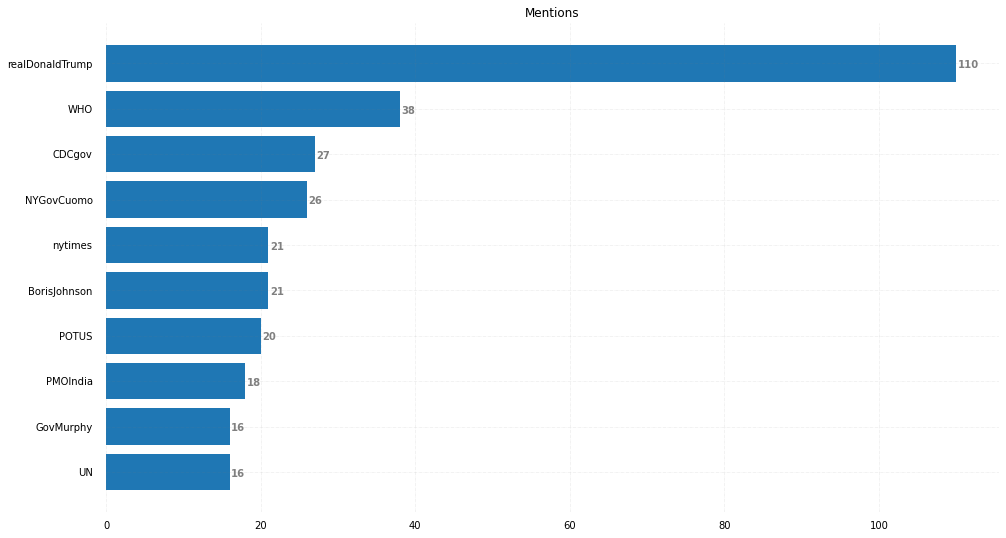

In [ ]:
first_n_nodes_barplot(sorted_degree_mentions, 10, 'Mentions')

### Sorted centrality comparison

In [ ]:
# Network properties extracted from Gephi
G_mentions_final = pd.read_csv(path + 'mentions_statistics.csv')

In [ ]:
degree_centrality_mentions = nx.degree_centrality(G_mentions)
betweenness_centrality_mentions = dict(zip(G_mentions_final['Id'], G_mentions_final['betweenesscentrality']))
closeness_centrality_mentions = dict(zip(G_mentions_final['Id'], G_mentions_final['closnesscentrality']))
pageranks_mentions = dict(zip(G_mentions_final['Id'], G_mentions_final['pageranks']))
eigen_centrality_mentions = dict(zip(G_mentions_final['Id'], G_mentions_final['eigencentrality']))

In [ ]:
print('Degree centrality:')
deg_cent_m = extract_n_most_highest_indexes(degree_centrality_mentions, 5)
deg_cent_df = pd.DataFrame(deg_cent_m, columns = ['Mention', 'Value'])
deg_cent_df

Degree centrality:


,Mention,Value
0,realDonaldTrump,0.025895
1,WHO,0.008945
2,CDCgov,0.006356
3,NYGovCuomo,0.006121
4,nytimes,0.004944


In [ ]:
print('Betweenness centrality:')
bet_cent_m = extract_n_most_highest_indexes(betweenness_centrality_mentions, 5)
bet_cent_df = pd.DataFrame(bet_cent_m, columns = ['Mention', 'Value'])
bet_cent_df

Betweenness centrality:


,Mention,Value
0,realDonaldTrump,0.008048
1,WHO,0.002808
2,CDCgov,0.002497
3,POTUS,0.002252
4,AamerAnwar,0.001284


In [ ]:
print('Closeness centrality:')
clo_cent_m = extract_n_most_highest_indexes(closeness_centrality_mentions, 5)
clo_cent_df = pd.DataFrame(clo_cent_m, columns = ['Mention', 'Value'])
clo_cent_df

Closeness centrality:


,Mention,Value
0,RonWyden,1.0
1,ABSCBNNews,1.0
2,FredTJoseph,1.0
3,UN_Women,1.0
4,UFWupdates,1.0


In [ ]:
# Percentage of nodes have closeness centrality equal to 1
count_closeness = sum(value == 1 for value in closeness_centrality_mentions.values())
print("Percentage of nodes have closeness centrality equal to 1: {}%".format(np.round(count_closeness*100/len(closeness_centrality_mentions),2)))

Percentage of nodes have closeness centrality equal to 1: 29.75%


In [ ]:
print('EigenCentrality:')
eig_cent_m = extract_n_most_highest_indexes(eigen_centrality_mentions, 5)
eig_cent_df = pd.DataFrame(eig_cent_m, columns = ['Mention', 'Value'])
eig_cent_df

EigenCentrality:


,Mention,Value
0,realDonaldTrump,1.000000
1,CDCgov,0.321052
2,POTUS,0.261970
3,WhiteHouse,0.236103
4,NYGovCuomo,0.229847


In [ ]:
print('PageRank:')
pag_rank_m = extract_n_most_highest_indexes(pageranks_mentions, 5)
pag_rank_df = pd.DataFrame(pag_rank_m, columns = ['Mention', 'Value'])
pag_rank_df

PageRank:


,Mention,Value
0,realDonaldTrump,0.001419
1,WHO,0.000502
2,CDCgov,0.000347
3,NYGovCuomo,0.000332
4,nytimes,0.000274


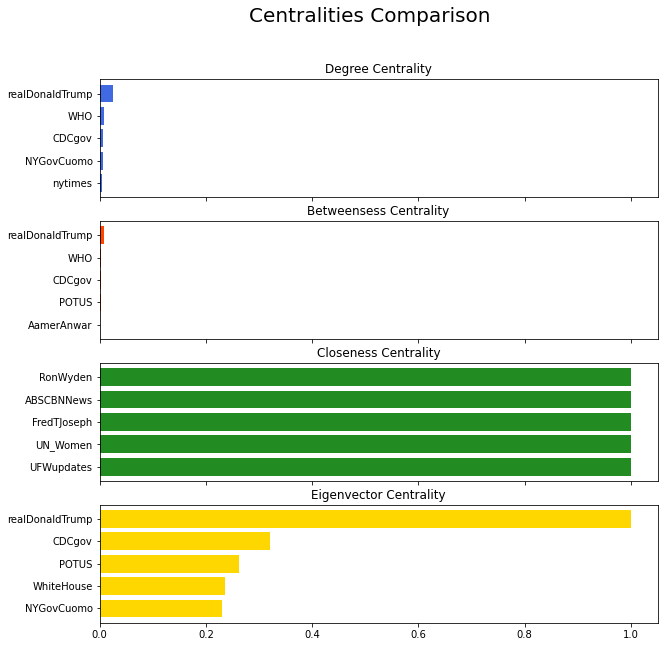

In [ ]:
centralities_comparison(deg_cent_m, bet_cent_m, clo_cent_m, eig_cent_m, pag_rank_m)

# Sentiment analysis

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.2 MB/s 


In [ ]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
# create a sentiment analyser
analyzer = SentimentIntensityAnalyzer()

In [ ]:
tweets_filtered.columns

Index(['created_at', 'id_str', 'text', 'user', 'retweeted_status',
       'quote_count', 'reply_count', 'retweet_count', 'favorite_count',
       'entities', 'clean_text', 'text_tokenized', 'user_location', 'hashtags',
       'mentions'],
      dtype='object')

In [ ]:
tweets_compound = [] # list of tweets evaluation sentiment  [-1=neg,1=pos]
for tweet in tweets_filtered.text:
  sentiment_map = analyzer.polarity_scores(tweet)       # sentiment map: dict keys:"pos","compound","neg"
  tweets_compound.append(sentiment_map['compound'])

tweets_filtered["compound"] = tweets_compound

In [ ]:
sum(tweets_filtered.compound == 0)

1609

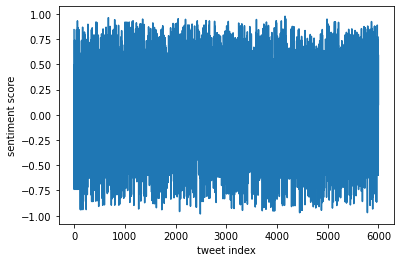

In [ ]:
plt.figure()
plt.plot(tweets_filtered.index, tweets_filtered.compound)
plt.ylabel('sentiment score')
plt.xlabel('tweet index')
plt.show()

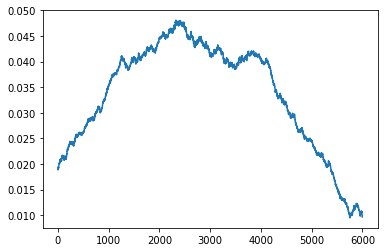

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    # generate values by taking the sum of the products of values within the input arch and the other signal (ones)
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def plt_compound(data): 
    smoothed_signals = smooth(list(data.compound), 4500)
    plt.figure()
    plt.plot(data.index, smoothed_signals)
    plt.show()
    
plt_compound(tweets_filtered)

After considering the sentiment score of each tweet, we want to plot the frequency of the compound score. The black line represents the mean, while the red and the green one represent respectively the first and third quantile. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



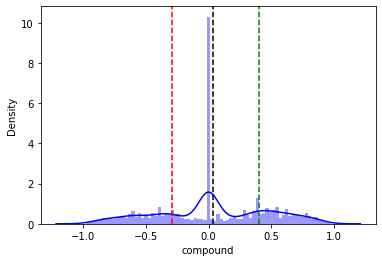

In [ ]:
def freq_compound(data):
    sns.distplot(data.compound, bins=75, color='b')
    plt.axvline(x=np.mean(data.compound), color='black', ls='--')               # mean of compound
    plt.axvline(x=np.quantile(data.compound, 0.75), color='green', ls='--')     # third quartile of compound
    plt.axvline(x=np.quantile(data.compound, 0.25), color='red', ls='--')       # first quartile of compound
    plt.show()
    
freq_compound(tweets_filtered)

Given that the number of tweets whose compound score is equal to 0 is very high, in order to better visualize the distribution we consider the tweets whose compound score is different from 0. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



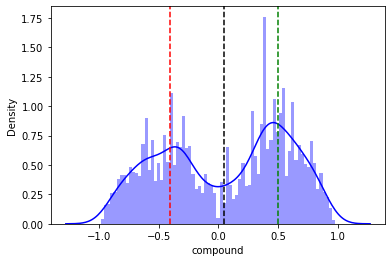

In [ ]:
freq_compound(tweets_filtered[tweets_filtered.compound != 0])

Furthermore, we can discretize the value of the compound in three classes: negative, positive and neutral, adding this information to a new column of the DataFrame.

- if $compound < -0.05$: the sentiment is negative
- if $compound > 0.05$: the sentiment is positive
- if $-0.05 < compound < 0.05$: the sentiment is neutral

In [ ]:
def discretize_values(values, thr):
    discretized_values = []
    for value in values:
        if value < -thr:
            discretized_values.append("negative")
        elif -thr <= value <= thr:
            discretized_values.append("neutral")
        else:
            discretized_values.append("positive")
    return discretized_values

thr=0.05
discrete_pol_scores = discretize_values(tweets_compound, thr)
    
tweets_filtered["text_score"] = discrete_pol_scores

In [ ]:
sum(tweets_filtered['text_score'] == 'negative')

1957

In [ ]:
def freq_discrete(data):
    freq_map = {'negative': 0, 'neutral': 0, 'positive': 0}
    freq_map["positive"] = list(data.text_score).count("positive")
    freq_map["neutral"] = list(data.text_score).count("neutral")
    freq_map["negative"] = list(data.text_score).count("negative")
    print(freq_map)
    plt.figure(figsize=(9,7.5))
    plt.pie(freq_map.values(), labels = freq_map.keys(), autopct='%1.1f%%', colors=['r', 'b', 'g'] )

{'negative': 1957, 'neutral': 1696, 'positive': 2347}


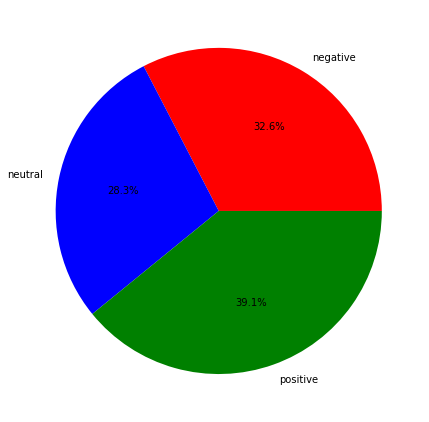

In [ ]:
freq_discrete(tweets_filtered)

In [ ]:
def df_country(country):
    if country not in list(tweets_filtered.user_location):
        raise NameError(f"{country} is not in df['user_location']")
    else:
        return tweets_filtered[tweets_filtered.user_location == country]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



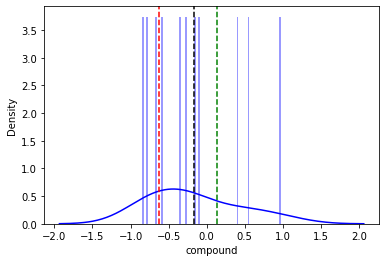

{'negative': 8, 'neutral': 1, 'positive': 3}


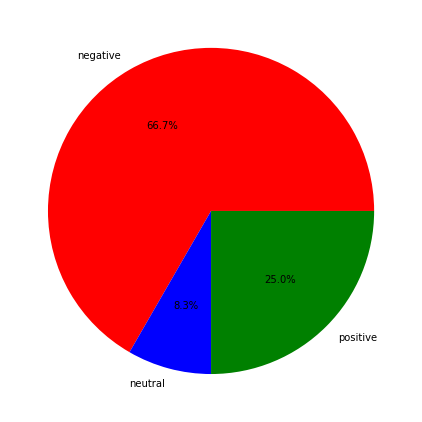

In [ ]:
freq_compound(df_country('Italy')[df_country('Italy').compound != 0])
freq_discrete(df_country('Italy'))

In [ ]:
tweets_filtered.loc[tweets_filtered['user_location'] == "Italy"]['text_tokenized']

1       [matter, time, growth, rate, really, high, lockdown, asap]                                            
217     [thread, cancer, patients, need, change, radiotherapy, practice, pandemic, radiotherapy, practic]     
605     [earth, president, clinton, leading, coordinated, effort, combat, allies, europe, asia, americas]     
848     [happy, seeing, shelter, animals, getting, adopted, fostered, due, covid, one, ever, picks, lexi, sp] 
874     [learn, anything, new, last, two, weeks, tried, many, times, warn, seriousness]                       
1094    [us, course, worst, number, cases, world, trajectory, becoming, almost, vertic]                       
1898    [moment, told, quiet, asked, cdc, overestimated, risk]                                                
2961    [floor, covid]                                                                                        
4159    [love, covid, advertisement, tv, thank]                                                               
4